In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob
from matplotlib.colors import Normalize
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt, decimate
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks
from skimage.morphology import skeletonize


# Assigned ranges for analysis
range1=("092022", "092212")
range2=("091122", "091312")
range3=("090302", "090452")


# Data loading

In [2]:
def get_range(ts_start: str, ts_end: str, dx=5.1065, dt=0.0016):
    files = glob.glob("../data/*.npy")
    files.sort()
    
    def extract_ts(path):
        fname = path.split("\\")[-1].split("/")[-1].split(".")[0]
        return datetime.datetime.strptime("2024-05-07 " + fname, "%Y-%m-%d %H%M%S")
    
    ts_start_dt = datetime.datetime.strptime("2024-05-07 " + ts_start, "%Y-%m-%d %H%M%S")
    ts_end_dt = datetime.datetime.strptime("2024-05-07 " + ts_end, "%Y-%m-%d %H%M%S")
    
    selected = []
    timestamps = []
    for f in files:
        ts = extract_ts(f)
        if ts_start_dt <= ts <= ts_end_dt:
            selected.append(f)
            timestamps.append(ts)
    
    if not selected:
        raise ValueError("No files found between the given timestamps.")
    
    arrays = [np.load(f) for f in selected]
    data = np.concatenate(arrays)
    
    index = pd.date_range(start=timestamps[0], periods=len(data), freq=f"{dt}s")
    columns = np.arange(data.shape[1]) * dx
    df = pd.DataFrame(data=data, index=index, columns=columns)
    
    return {"data": data, "df": df, "dt": dt, "dx": dx}

# Plotting

In [3]:
def set_axis(axis_data):
    """Helper function to set axis ticks"""
    n = len(axis_data)
    positions = np.linspace(0, n-1, min(10, n))
    labels = [axis_data[int(p)] for p in positions]
    return positions, labels

def plot_data(result, figsize=(12, 16), cmap='viridis', apply_transform=True, percentiles=[3, 99]):
    """
    Plot DAS data as a heatmap (time vs distance).
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    figsize : tuple
        Figure size (width, height)
    cmap : str
        Colormap for the plot
    apply_transform : bool
        If True, applies mean subtraction and absolute value transform
    percentiles : list
        Percentile values [low, high] for color normalization
    
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """
    df = result['df'].copy()
    
    # Apply transformation
    if apply_transform:
        df -= df.mean()
        df = np.abs(df)
    
    # Normalize using percentiles
    low, high = np.percentile(df, percentiles)
    norm = Normalize(vmin=low, vmax=high, clip=True)
    
    fig = plt.figure(figsize=figsize)
    ax = plt.axes()
    
    # Plot the data
    im = ax.imshow(df, interpolation='none', aspect='auto', norm=norm, cmap=cmap)
    
    plt.ylabel('time')
    plt.xlabel('space [m]')
    
    # Add colorbar with custom positioning
    cax = fig.add_axes([ax.get_position().x1+0.06, ax.get_position().y0, 0.02, ax.get_position().height])
    plt.colorbar(im, cax=cax)
    
    # Set axis ticks
    x_positions, x_labels = set_axis(df.columns)
    ax.set_xticks(x_positions, np.round(x_labels))
    
    y_positions, y_labels = set_axis(df.index.time)
    ax.set_yticks(y_positions, y_labels)
    
    plt.show()
    
    return fig, ax

def plot_comparison(result1, result2, title1="Original", title2="Processed", 
                    figsize=(24, 16), cmap='viridis', apply_transform=True, percentiles=[3, 99]):
    """
    Plot two DAS datasets side by side for comparison.
    
    Parameters:
    -----------
    result1, result2 : dict
        Dictionaries returned by get_range() or filter functions
    title1, title2 : str
        Titles for the left and right plots
    figsize : tuple
        Figure size (width, height)
    cmap : str
        Colormap for the plots
    apply_transform : bool
        If True, applies mean subtraction and absolute value transform
    percentiles : list
        Percentile values [low, high] for color normalization
    
    Returns:
    --------
    fig, (ax1, ax2) : matplotlib figure and axes objects
    """
    df1 = result1['df'].copy()
    df2 = result2['df'].copy()
    
    # Apply transformation
    if apply_transform:
        df1 -= df1.mean()
        df1 = np.abs(df1)
        df2 -= df2.mean()
        df2 = np.abs(df2)
    
    # Normalize using percentiles
    low, high = np.percentile(df1, percentiles)
    low2, high2 = np.percentile(df2, percentiles)
    norm = Normalize(vmin=low, vmax=high, clip=True)
    norm2 = Normalize(vmin=low2, vmax=high2, clip=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot left (original)
    im1 = ax1.imshow(df1, interpolation='none', aspect='auto', norm=norm, cmap=cmap)
    ax1.set_ylabel('time')
    ax1.set_xlabel('space [m]')
    ax1.set_title(title1)
    
    x_positions1, x_labels1 = set_axis(df1.columns)
    ax1.set_xticks(x_positions1, np.round(x_labels1))
    y_positions1, y_labels1 = set_axis(df1.index.time)
    ax1.set_yticks(y_positions1, y_labels1)
    
    # Plot right (processed)
    im2 = ax2.imshow(df2, interpolation='none', aspect='auto', norm=norm2, cmap=cmap)
    ax2.set_ylabel('time')
    ax2.set_xlabel('space [m]')
    ax2.set_title(title2)
    
    x_positions2, x_labels2 = set_axis(df2.columns)
    ax2.set_xticks(x_positions2, np.round(x_labels2))
    y_positions2, y_labels2 = set_axis(df2.index.time)
    ax2.set_yticks(y_positions2, y_labels2)
    
    # Add colorbars
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('Amplitude')
    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.set_label('Amplitude')
    
    plt.tight_layout()
    plt.show()
    
    return fig, (ax1, ax2)

# Preprocessing

In [4]:
def bandpass_filter(result, lowcut=5, highcut=50, order=4):
    """
    Apply bandpass filter to DAS data to isolate vehicle frequencies.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    lowcut : float
        Low cutoff frequency in Hz (default: 5 Hz)
    highcut : float
        High cutoff frequency in Hz (default: 50 Hz)
    order : int
        Filter order (default: 4)
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data']
    df = result['df']
    
    # Calculate sampling frequency
    fs = 1.0 / dt
    
    # Normalize cutoff frequencies
    nyquist = fs / 2.0
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Design Butterworth bandpass filter
    b, a = butter(order, [low, high], btype='band')
    
    # Apply filter to each spatial channel (column)
    filtered_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        filtered_data[:, i] = filtfilt(b, a, data[:, i])
    
    # Create filtered DataFrame with same index and columns
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

def median_subtract_filter(result):
    """
    Subtract the median value from each channel to remove DC offset and baseline drift.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    
    Returns:
    --------
    dict : Same structure as input with median-subtracted data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data']
    df = result['df']
    
    # Subtract median from each channel (column)
    filtered_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        filtered_data[:, i] = data[:, i] - np.median(data[:, i])
    
    # Create filtered DataFrame with same index and columns
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }
    
def zero_columns(data, col_start, col_end):
    # Zero out specified columns in the DAS data.
    dt = data['dt']
    dx = data['dx']
    array = data['data']
    df = data['df']
    modified_array = array.copy()
    modified_array[:, col_start:col_end] = 0
    modified_df = pd.DataFrame(
        data=modified_array,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': modified_array,
        'df': modified_df,
        'dt': dt,
        'dx': dx
    }

def power_data_to_x(data, power=2):
    # Raise the absolute value of the data to a specified power.
    dt = data['dt']
    dx = data['dx']
    array = data['data']
    df = data['df']
    modified_array = np.abs(array) ** power
    modified_df = pd.DataFrame(
        data=modified_array,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': modified_array,
        'df': modified_df,
        'dt': dt,
        'dx': dx
    }
    

# Other functions

In [5]:
def find_channel_frequencies(result, channel_index=24, threshold_percentile=85, 
                            merge_gap=50, min_sector_length=3):
    """
    Find frequencies of continuous high-amplitude sectors on a specific channel.
    
    This function identifies continuous segments (sectors) on a single channel that
    exceed a threshold, merges nearby sectors, then calculates their frequencies based on duration.
    
    Parameters:
    -----------
    result : dict
        Dictionary from get_range() containing 'data', 'df', 'dt', 'dx'
    channel_index : int
        Index of the channel to analyze (default: 24)
    threshold_percentile : float
        Percentile threshold for sector detection (default: 85)
    merge_gap : int
        Maximum gap (in samples) between sectors to merge them (default: 50)
    min_sector_length : int
        Minimum sector length (in samples) to keep (default: 3)
    
    Returns:
    --------
    dict : Analysis results containing:
        'frequencies': array of frequencies [Hz] for each detected sector group
        'durations': array of sector durations [seconds]
        'sector_lengths': array of sector lengths [samples]
        'starts': array of sector start indices
        'ends': array of sector end indices
        'num_merged': array showing how many original sectors were merged
    """
    dt = result['dt']
    data = result['data']
    
    # Get the specific channel data
    channel_data = data[:, channel_index]
    
    # Calculate threshold
    threshold = np.percentile(np.abs(channel_data), threshold_percentile)
    
    # Create binary signal where channel exceeds threshold
    binary_signal = (np.abs(channel_data) > threshold).astype(int)
    
    # Find continuous segments (sectors)
    # Where signal changes from 0 to 1 or 1 to 0
    diff = np.diff(np.concatenate(([0], binary_signal, [0])))
    starts_raw = np.where(diff == 1)[0]
    ends_raw = np.where(diff == -1)[0]
    
    # Filter out very short sectors
    sector_lengths_raw = ends_raw - starts_raw
    valid_mask = sector_lengths_raw >= min_sector_length
    starts_raw = starts_raw[valid_mask]
    ends_raw = ends_raw[valid_mask]
    
    print(f"Initial sectors detected: {len(starts_raw)}")
    
    # Merge nearby sectors
    if len(starts_raw) == 0:
        starts = np.array([])
        ends = np.array([])
        num_merged = np.array([])
    else:
        merged_starts = [starts_raw[0]]
        merged_ends = [ends_raw[0]]
        num_merged_list = [1]
        
        for i in range(1, len(starts_raw)):
            gap = starts_raw[i] - merged_ends[-1]
            
            if gap <= merge_gap:
                # Merge with previous sector
                merged_ends[-1] = ends_raw[i]
                num_merged_list[-1] += 1
            else:
                # Start new sector
                merged_starts.append(starts_raw[i])
                merged_ends.append(ends_raw[i])
                num_merged_list.append(1)
        
        starts = np.array(merged_starts)
        ends = np.array(merged_ends)
        num_merged = np.array(num_merged_list)
    
    # Calculate properties for each merged sector
    sector_lengths = ends - starts  # Length in samples
    durations = sector_lengths * dt  # Duration in seconds
    
    # Calculate frequency for each sector: f = 1 / T
    frequencies = np.array([1.0 / duration if duration > 0 else 0 for duration in durations])
    
    print("="*70)
    print(f"CHANNEL {channel_index} FREQUENCY ANALYSIS")
    print("="*70)
    print(f"\nData parameters:")
    print(f"  Temporal resolution (dt): {dt*1000:.2f} ms")
    print(f"  Channel index: {channel_index}")
    print(f"  Threshold (percentile {threshold_percentile}): {threshold:.6f}")
    print(f"  Merge gap: {merge_gap} samples ({merge_gap * dt * 1000:.2f} ms)")
    print(f"  Min sector length: {min_sector_length} samples ({min_sector_length * dt * 1000:.2f} ms)")
    print(f"  Merged sectors detected: {len(frequencies)}")
    
    if len(frequencies) > 0:
        print(f"\n{'='*70}")
        print(f"DETECTED MERGED SECTORS:")
        print(f"{'='*70}")
        print(f"{'#':<6} {'Start':<10} {'End':<10} {'Length':<12} {'Duration':<15} {'Frequency':<12} {'Merged':<8}")
        print(f"{'-'*70}")
        
        for i, (start, end, length, duration, freq, n_merged) in enumerate(zip(starts, ends, sector_lengths, durations, frequencies, num_merged)):
            if i < 20:  # Show first 20
                print(f"{i+1:<6} {start:<10} {end:<10} {length:<12} {duration*1000:>10.2f} ms   {freq:>10.2f} Hz   {n_merged:<8}")
        
        if len(frequencies) > 20:
            print(f"... and {len(frequencies) - 20} more sectors")
        
        print(f"{'='*70}")
        print(f"\nSUMMARY STATISTICS:")
        print(f"  Total sectors: {len(frequencies)}")
        print(f"  Sector lengths: {np.min(sector_lengths)} to {np.max(sector_lengths)} samples")
        print(f"  Durations: {np.min(durations)*1000:.2f} to {np.max(durations)*1000:.2f} ms")
        print(f"  Frequencies: {np.min(frequencies):.2f} to {np.max(frequencies):.2f} Hz")
        print(f"  Mean frequency: {np.mean(frequencies):.2f} Hz")
        print(f"  Median frequency: {np.median(frequencies):.2f} Hz")
        
        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=(20, 10))
        
        # Plot 1: Channel signal with threshold
        ax = axes[0, 0]
        time_axis = np.arange(len(channel_data)) * dt
        ax.plot(time_axis, channel_data, 'b-', linewidth=0.5, alpha=0.7, label='Signal')
        ax.axhline(threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold ({threshold_percentile}%)')
        ax.axhline(-threshold, color='r', linestyle='--', linewidth=2)
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Amplitude')
        ax.set_title(f'Channel {channel_index} Signal', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 2: Binary signal with sectors highlighted
        ax = axes[0, 1]
        ax.plot(time_axis, binary_signal, 'k-', linewidth=1)
        for start, end in zip(starts[:50], ends[:50]):  # Highlight first 50 sectors
            ax.axvspan(start * dt, end * dt, alpha=0.3, color='green')
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Binary (0/1)')
        ax.set_title('Detected Sectors (first 50 highlighted)', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Plot 3: Frequency histogram
        ax = axes[1, 0]
        ax.hist(frequencies, bins=50, edgecolor='black', alpha=0.7)
        ax.axvline(np.mean(frequencies), color='r', linestyle='--', 
                   linewidth=2, label=f'Mean: {np.mean(frequencies):.2f} Hz')
        ax.axvline(np.median(frequencies), color='g', linestyle='--', 
                   linewidth=2, label=f'Median: {np.median(frequencies):.2f} Hz')
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('Count')
        ax.set_title('Frequency Distribution', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 4: Duration vs Frequency scatter
        ax = axes[1, 1]
        ax.scatter(durations * 1000, frequencies, alpha=0.5, s=20)
        ax.set_xlabel('Duration [ms]')
        ax.set_ylabel('Frequency [Hz]')
        ax.set_title('Duration vs Frequency', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo sectors detected above threshold.")
    
    print(f"{'='*70}\n")
    
    return {
        'frequencies': frequencies,
        'durations': durations,
        'sector_lengths': sector_lengths,
        'starts': starts,
        'ends': ends,
        'num_merged': num_merged,
        'channel_index': channel_index,
        'threshold': threshold
    }

def notch_filter_frequencies(result, frequencies_to_remove, bandwidth=2.0, order=2):
    """
    Apply notch filters to remove specific frequencies from DAS data.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    frequencies_to_remove : array-like
        List or array of frequencies [Hz] to remove from the signal
    bandwidth : float
        Bandwidth of each notch filter in Hz (default: 2.0)
    order : int
        Filter order for each notch (default: 2)
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from scipy.signal import iirnotch
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    # Calculate sampling frequency
    fs = 1.0 / dt
    
    print("="*70)
    print("NOTCH FILTERING")
    print("="*70)
    print(f"Sampling frequency: {fs:.2f} Hz")
    print(f"Removing {len(frequencies_to_remove)} frequencies:")
    
    # Apply notch filter for each frequency
    filtered_data = data.copy()
    
    for freq in frequencies_to_remove:
        if freq <= 0 or freq >= fs / 2:
            print(f"  Skipping {freq:.2f} Hz (out of valid range)")
            continue
        
        # Design notch filter
        # Q factor determines bandwidth: BW = freq / Q
        Q = freq / bandwidth
        b, a = iirnotch(freq, Q, fs)
        
        # Apply filter to each spatial channel
        for i in range(filtered_data.shape[1]):
            filtered_data[:, i] = filtfilt(b, a, filtered_data[:, i])
        
        print(f"  Removed {freq:.2f} Hz (Q={Q:.2f}, BW={bandwidth:.2f} Hz)")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    print("="*70 + "\n")
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

def bandstop_filter_frequencies(result, frequencies_to_remove, bandwidth=5.0, order=4):
    """
    Apply bandstop (band-reject) filters to remove specific frequency bands from DAS data.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    frequencies_to_remove : array-like
        List or array of center frequencies [Hz] to remove from the signal
    bandwidth : float
        Bandwidth around each center frequency to remove in Hz (default: 5.0)
    order : int
        Filter order (default: 4)
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    # Calculate sampling frequency
    fs = 1.0 / dt
    nyquist = fs / 2.0
    
    print("="*70)
    print("BANDSTOP FILTERING")
    print("="*70)
    print(f"Sampling frequency: {fs:.2f} Hz")
    print(f"Removing {len(frequencies_to_remove)} frequency bands:")
    
    # Apply bandstop filter for each frequency
    filtered_data = data.copy()
    
    for freq in frequencies_to_remove:
        # Calculate lowcut and highcut
        lowcut = freq - bandwidth / 2
        highcut = freq + bandwidth / 2
        
        # Validate frequency range
        if lowcut <= 0 or highcut >= nyquist:
            print(f"  Skipping {freq:.2f} Hz (band {lowcut:.2f}-{highcut:.2f} Hz out of valid range)")
            continue
        
        # Normalize cutoff frequencies
        low = lowcut / nyquist
        high = highcut / nyquist
        
        # Design bandstop filter
        b, a = butter(order, [low, high], btype='bandstop')
        
        # Apply filter to each spatial channel
        for i in range(filtered_data.shape[1]):
            filtered_data[:, i] = filtfilt(b, a, filtered_data[:, i])
        
        print(f"  Removed {lowcut:.2f}-{highcut:.2f} Hz (center: {freq:.2f} Hz)")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    print("="*70 + "\n")
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

def bandpass_keep_frequencies(result, frequencies_to_keep, bandwidth=5.0, order=4):
    """
    Apply bandpass filters to KEEP ONLY specific frequencies from DAS data.
    All other frequencies will be removed.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    frequencies_to_keep : array-like
        List or array of center frequencies [Hz] to KEEP in the signal
    bandwidth : float
        Bandwidth around each center frequency to keep in Hz (default: 5.0)
    order : int
        Filter order (default: 4)
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    # Calculate sampling frequency
    fs = 1.0 / dt
    nyquist = fs / 2.0
    
    print("="*70)
    print("BANDPASS KEEP ONLY SPECIFIC FREQUENCIES")
    print("="*70)
    print(f"Sampling frequency: {fs:.2f} Hz")
    print(f"Keeping {len(frequencies_to_keep)} frequency bands:")
    
    # Start with zeros - we'll add each frequency band
    filtered_data = np.zeros_like(data)
    
    for freq in frequencies_to_keep:
        # Calculate lowcut and highcut
        lowcut = freq - bandwidth / 2
        highcut = freq + bandwidth / 2
        
        # Validate frequency range
        if lowcut <= 0 or highcut >= nyquist:
            print(f"  Skipping {freq:.2f} Hz (band {lowcut:.2f}-{highcut:.2f} Hz out of valid range)")
            continue
        
        # Normalize cutoff frequencies
        low = lowcut / nyquist
        high = highcut / nyquist
        
        # Design bandpass filter
        b, a = butter(order, [low, high], btype='bandpass')
        
        # Apply filter to each spatial channel and ADD to result
        for i in range(data.shape[1]):
            filtered_data[:, i] += filtfilt(b, a, data[:, i])
        
        print(f"  Kept {lowcut:.2f}-{highcut:.2f} Hz (center: {freq:.2f} Hz)")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    print("="*70 + "\n")
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }


In [6]:
def find_channel_frequencies_fft(result, channel_index=24, threshold_percentile=85, 
                                merge_gap=50, min_sector_length=3, 
                                min_freq=5, max_freq=50, top_n_peaks=1):
    """
    Find dominant signal frequencies using FFT analysis of high-amplitude sectors.
    
    Instead of calculating f=1/duration, this function applies FFT to each detected
    sector to find the actual oscillation frequencies in the signal content.
    
    Parameters:
    -----------
    result : dict
        Dictionary from get_range() containing 'data', 'df', 'dt', 'dx'
    channel_index : int
        Index of the channel to analyze (default: 24)
    threshold_percentile : float
        Percentile threshold for sector detection (default: 85)
    merge_gap : int
        Maximum gap (in samples) between sectors to merge them (default: 50)
    min_sector_length : int
        Minimum sector length (in samples) to keep (default: 3)
    min_freq : float
        Minimum frequency to consider in FFT analysis [Hz] (default: 5)
    max_freq : float
        Maximum frequency to consider in FFT analysis [Hz] (default: 50)
    top_n_peaks : int
        Number of top frequency peaks to extract per sector (default: 1)
    
    Returns:
    --------
    dict : Analysis results containing:
        'frequencies': array of dominant frequencies [Hz] found via FFT
        'peak_powers': array of FFT peak powers for each frequency
        'sector_frequencies': list of arrays, each containing top frequencies for one sector
        'durations': array of sector durations [seconds]
        'sector_lengths': array of sector lengths [samples]
        'starts': array of sector start indices
        'ends': array of sector end indices
        'num_merged': array showing how many original sectors were merged
    """
    from scipy.fft import rfft, rfftfreq
    
    dt = result['dt']
    data = result['data']
    fs = 1.0 / dt
    
    # Get the specific channel data
    channel_data = data[:, channel_index]
    
    # Calculate threshold
    threshold = np.percentile(np.abs(channel_data), threshold_percentile)
    
    # Create binary signal where channel exceeds threshold
    binary_signal = (np.abs(channel_data) > threshold).astype(int)
    
    # Find continuous segments (sectors)
    diff = np.diff(np.concatenate(([0], binary_signal, [0])))
    starts_raw = np.where(diff == 1)[0]
    ends_raw = np.where(diff == -1)[0]
    
    # Filter out very short sectors
    sector_lengths_raw = ends_raw - starts_raw
    valid_mask = sector_lengths_raw >= min_sector_length
    starts_raw = starts_raw[valid_mask]
    ends_raw = ends_raw[valid_mask]
    
    print(f"Initial sectors detected: {len(starts_raw)}")
    
    # Merge nearby sectors
    if len(starts_raw) == 0:
        starts = np.array([])
        ends = np.array([])
        num_merged = np.array([])
    else:
        merged_starts = [starts_raw[0]]
        merged_ends = [ends_raw[0]]
        num_merged_list = [1]
        
        for i in range(1, len(starts_raw)):
            gap = starts_raw[i] - merged_ends[-1]
            
            if gap <= merge_gap:
                merged_ends[-1] = ends_raw[i]
                num_merged_list[-1] += 1
            else:
                merged_starts.append(starts_raw[i])
                merged_ends.append(ends_raw[i])
                num_merged_list.append(1)
        
        starts = np.array(merged_starts)
        ends = np.array(merged_ends)
        num_merged = np.array(num_merged_list)
    
    # Calculate basic properties
    sector_lengths = ends - starts
    durations = sector_lengths * dt
    
    # FFT analysis for each sector
    all_frequencies = []
    all_peak_powers = []
    sector_frequencies_list = []
    
    for start, end in zip(starts, ends):
        # Extract sector signal
        sector_signal = channel_data[start:end]
        sector_length = len(sector_signal)
        
        # Apply FFT
        fft_result = rfft(sector_signal)
        fft_freqs = rfftfreq(sector_length, dt)
        fft_power = np.abs(fft_result)
        
        # Filter to frequency range of interest
        freq_mask = (fft_freqs >= min_freq) & (fft_freqs <= max_freq)
        valid_freqs = fft_freqs[freq_mask]
        valid_power = fft_power[freq_mask]
        
        if len(valid_freqs) == 0:
            continue
        
        # Find top N peaks
        n_peaks = min(top_n_peaks, len(valid_power))
        top_indices = np.argpartition(valid_power, -n_peaks)[-n_peaks:]
        top_indices = top_indices[np.argsort(valid_power[top_indices])[::-1]]
        
        sector_freqs = valid_freqs[top_indices]
        sector_powers = valid_power[top_indices]
        
        # Store results
        sector_frequencies_list.append(sector_freqs)
        all_frequencies.extend(sector_freqs)
        all_peak_powers.extend(sector_powers)
    
    frequencies = np.array(all_frequencies)
    peak_powers = np.array(all_peak_powers)
    
    print("="*70)
    print(f"CHANNEL {channel_index} FFT FREQUENCY ANALYSIS")
    print("="*70)
    print(f"\nData parameters:")
    print(f"  Temporal resolution (dt): {dt*1000:.2f} ms")
    print(f"  Sampling frequency (fs): {fs:.2f} Hz")
    print(f"  Channel index: {channel_index}")
    print(f"  Threshold (percentile {threshold_percentile}): {threshold:.6f}")
    print(f"  Merge gap: {merge_gap} samples ({merge_gap * dt * 1000:.2f} ms)")
    print(f"  Min sector length: {min_sector_length} samples ({min_sector_length * dt * 1000:.2f} ms)")
    print(f"  Frequency range: {min_freq}-{max_freq} Hz")
    print(f"  Top peaks per sector: {top_n_peaks}")
    print(f"  Merged sectors detected: {len(starts)}")
    print(f"  Total frequencies extracted: {len(frequencies)}")
    
    if len(frequencies) > 0:
        print(f"\n{'='*70}")
        print(f"DETECTED FREQUENCIES (via FFT):")
        print(f"{'='*70}")
        print(f"{'#':<6} {'Start':<10} {'End':<10} {'Length':<12} {'Duration':<15} {'Frequency':<12} {'Power':<12}")
        print(f"{'-'*70}")
        
        displayed = 0
        for i, (start, end, length, duration, n_merged) in enumerate(zip(starts, ends, sector_lengths, durations, num_merged)):
            if i < len(sector_frequencies_list):
                for freq, power in zip(sector_frequencies_list[i], 
                                      [peak_powers[j] for j in range(len(peak_powers)) 
                                       if j < len(sector_frequencies_list[i])]):
                    if displayed < 20:
                        print(f"{i+1:<6} {start:<10} {end:<10} {length:<12} {duration*1000:>10.2f} ms   {freq:>10.2f} Hz   {power:>10.2e}")
                        displayed += 1
        
        if len(frequencies) > 20:
            print(f"... and {len(frequencies) - 20} more frequencies")
        
        print(f"{'='*70}")
        print(f"\nSUMMARY STATISTICS:")
        print(f"  Total sectors: {len(starts)}")
        print(f"  Total frequencies: {len(frequencies)}")
        print(f"  Frequency range: {np.min(frequencies):.2f} to {np.max(frequencies):.2f} Hz")
        print(f"  Mean frequency: {np.mean(frequencies):.2f} Hz")
        print(f"  Median frequency: {np.median(frequencies):.2f} Hz")
        
        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=(20, 10))
        
        # Plot 1: Channel signal with threshold
        ax = axes[0, 0]
        time_axis = np.arange(len(channel_data)) * dt
        ax.plot(time_axis, channel_data, 'b-', linewidth=0.5, alpha=0.7, label='Signal')
        ax.axhline(threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold ({threshold_percentile}%)')
        ax.axhline(-threshold, color='r', linestyle='--', linewidth=2)
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Amplitude')
        ax.set_title(f'Channel {channel_index} Signal', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 2: Binary signal with sectors highlighted
        ax = axes[0, 1]
        ax.plot(time_axis, binary_signal, 'k-', linewidth=1)
        for start, end in zip(starts[:50], ends[:50]):
            ax.axvspan(start * dt, end * dt, alpha=0.3, color='green')
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Binary (0/1)')
        ax.set_title('Detected Sectors (first 50 highlighted)', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Plot 3: Frequency histogram
        ax = axes[1, 0]
        ax.hist(frequencies, bins=50, edgecolor='black', alpha=0.7)
        ax.axvline(np.mean(frequencies), color='r', linestyle='--', 
                   linewidth=2, label=f'Mean: {np.mean(frequencies):.2f} Hz')
        ax.axvline(np.median(frequencies), color='g', linestyle='--', 
                   linewidth=2, label=f'Median: {np.median(frequencies):.2f} Hz')
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('Count')
        ax.set_title('FFT Frequency Distribution', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 4: Frequency vs Power scatter
        ax = axes[1, 1]
        ax.scatter(frequencies, peak_powers, alpha=0.5, s=20)
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('FFT Power')
        ax.set_title('Frequency vs FFT Power', fontsize=14, fontweight='bold')
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo frequencies detected in specified range.")
    
    print(f"{'='*70}\n")
    
    return {
        'frequencies': frequencies,
        'peak_powers': peak_powers,
        'sector_frequencies': sector_frequencies_list,
        'durations': durations,
        'sector_lengths': sector_lengths,
        'starts': starts,
        'ends': ends,
        'num_merged': num_merged,
        'channel_index': channel_index,
        'threshold': threshold
    }

In [7]:
def percentile_filter(result, lower_percentile=10, upper_percentile=90):
    """
    Filter data to keep only values between specified percentiles.
    Values outside the range are set to the corresponding percentile boundary.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    lower_percentile : float
        Lower percentile threshold (0-100, default: 10)
    upper_percentile : float
        Upper percentile threshold (0-100, default: 90)
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    # Calculate percentile thresholds
    lower_threshold = np.percentile(data, lower_percentile)
    upper_threshold = np.percentile(data, upper_percentile)
    
    print("="*70)
    print("PERCENTILE FILTERING")
    print("="*70)
    print(f"Lower percentile ({lower_percentile}%): {lower_threshold:.6f}")
    print(f"Upper percentile ({upper_percentile}%): {upper_threshold:.6f}")
    
    # Clip values to percentile range
    filtered_data = np.clip(data, lower_threshold, upper_threshold)
    
    # Calculate statistics
    original_range = np.max(data) - np.min(data)
    filtered_range = upper_threshold - lower_threshold
    percent_reduced = (1 - filtered_range / original_range) * 100
    
    print(f"\nOriginal data range: {np.min(data):.6f} to {np.max(data):.6f}")
    print(f"Filtered data range: {lower_threshold:.6f} to {upper_threshold:.6f}")
    print(f"Range reduction: {percent_reduced:.2f}%")
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

In [8]:
def horizontal_closing_filter(result, kernel_size=5, threshold_percentile=50):
    """
    Apply morphological closing filter horizontally to fill gaps in high-intensity areas.
    This connects broken line segments along the time axis (horizontal direction).
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    kernel_size : int
        Size of the horizontal structuring element (default: 5)
        Larger values close bigger gaps
    threshold_percentile : float
        Percentile threshold to binarize data before morphological operation (default: 50)
        Higher values = more selective (only strongest signals)
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from scipy.ndimage import binary_closing
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    # Calculate threshold for binarization
    threshold = np.percentile(np.abs(data), threshold_percentile)
    
    print("="*70)
    print("HORIZONTAL CLOSING FILTER")
    print("="*70)
    print(f"Kernel size: {kernel_size} samples ({kernel_size * dt * 1000:.2f} ms)")
    print(f"Threshold percentile: {threshold_percentile}%")
    print(f"Threshold value: {threshold:.6f}")
    
    # Create horizontal structuring element (1 x kernel_size)
    # This only operates along time axis (rows), not space axis (columns)
    structure = np.zeros((1, kernel_size))
    structure[0, :] = 1
    
    print(f"Structuring element shape: {structure.shape} (vertical x horizontal)")
    
    # Process each channel independently
    filtered_data = np.zeros_like(data)
    
    for i in range(data.shape[1]):
        channel_data = data[:, i]
        
        # Binarize: 1 where above threshold, 0 elsewhere
        binary_data = (np.abs(channel_data) > threshold).astype(int)
        
        # Apply morphological closing horizontally
        # This fills small gaps between high-intensity regions
        closed_binary = binary_closing(binary_data.reshape(-1, 1), structure=structure)
        
        # Apply binary mask to original data
        # Where closing filled gaps, interpolate values
        filled_mask = closed_binary.flatten()
        filtered_channel = channel_data.copy()
        
        # For newly filled regions, use interpolated values
        newly_filled = (filled_mask == 1) & (binary_data == 0)
        if np.any(newly_filled):
            # Simple interpolation: use mean of surrounding high values
            filtered_channel[newly_filled] = np.mean(channel_data[binary_data == 1]) if np.any(binary_data) else 0
        
        filtered_data[:, i] = filtered_channel
    
    # Calculate statistics
    original_high_intensity = np.sum(np.abs(data) > threshold)
    filtered_high_intensity = np.sum(np.abs(filtered_data) > threshold)
    added_samples = filtered_high_intensity - original_high_intensity
    
    print(f"\nOriginal high-intensity samples: {original_high_intensity}")
    print(f"After closing: {filtered_high_intensity}")
    print(f"Samples added (gaps filled): {added_samples}")
    print(f"Percentage increase: {(added_samples / original_high_intensity * 100):.2f}%")
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

In [9]:
def horizontal_sobel_filter(result, intensity=1.0, channel_independent=False):
    """
    Apply horizontal Sobel filter to detect edges along the time axis.
    This enhances horizontal features like vehicle signatures moving across channels.
    
    The Sobel operator calculates the gradient in the horizontal direction,
    highlighting transitions and edges in the time domain.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    intensity : float
        Edge intensity multiplier (default: 1.0)
        Values > 1.0 increase contrast and edge visibility
        Values < 1.0 reduce edge intensity
        Recommended range: 0.5 to 5.0
    channel_independent : bool
        If True, process each channel independently (no cross-channel influence)
        If False, use standard 2D Sobel filter (default: False)
    
    Returns:
    --------
    dict : Same structure as input with Sobel-filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from scipy.ndimage import sobel
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("HORIZONTAL SOBEL FILTER")
    print("="*70)
    print(f"Data shape: {data.shape} (time x space)")
    print(f"Edge intensity multiplier: {intensity}")
    print(f"Channel independent: {channel_independent}")
    print(f"Applying horizontal gradient detection...")
    
    if channel_independent:
        # Process each channel independently using 1D gradient
        filtered_data = np.zeros_like(data)
        for i in range(data.shape[1]):
            # Use simple gradient along time axis for each channel
            channel_gradient = np.gradient(data[:, i])
            filtered_data[:, i] = channel_gradient
        print(f"  Mode: 1D gradient per channel (no cross-channel mixing)")
    else:
        # Apply standard 2D horizontal Sobel filter
        # axis=1 means horizontal direction (along time axis)
        filtered_data = sobel(data, axis=1)
        print(f"  Mode: 2D Sobel (includes cross-channel smoothing)")
    
    # Apply intensity multiplier
    filtered_data = filtered_data * intensity
    
    # Calculate statistics
    original_mean = np.mean(np.abs(data))
    filtered_mean = np.mean(np.abs(filtered_data))
    original_max = np.max(np.abs(data))
    filtered_max = np.max(np.abs(filtered_data))
    
    print(f"\nOriginal data:")
    print(f"  Mean absolute value: {original_mean:.6f}")
    print(f"  Max absolute value: {original_max:.6f}")
    print(f"\nFiltered data (horizontal edges):")
    print(f"  Mean absolute value: {filtered_mean:.6f}")
    print(f"  Max absolute value: {filtered_max:.6f}")
    print(f"  Amplitude ratio: {filtered_max / original_max:.2f}")
    print(f"  Edge enhancement: {intensity}x")
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

In [10]:
def wavelet_denoise_filter(result, wavelet='db4', level=None, threshold_scale=1.0):
    """
    Apply wavelet denoising to remove noise while preserving edges and features.
    This uses discrete wavelet transform (DWT) with soft thresholding.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    wavelet : str
        Wavelet family to use (default: 'db4' - Daubechies 4)
        Options: 'db1'-'db20', 'sym2'-'sym20', 'coif1'-'coif5', 'haar'
    level : int or None
        Decomposition level (default: None = automatic based on signal length)
    threshold_scale : float
        Scale factor for threshold (default: 1.0)
        Higher values = more aggressive denoising, Lower values = preserve more detail
    
    Returns:
    --------
    dict : Same structure as input with denoised data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    import pywt
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("WAVELET DENOISING FILTER")
    print("="*70)
    print(f"Wavelet: {wavelet}")
    print(f"Threshold scale: {threshold_scale}")
    
    # Determine decomposition level if not specified
    if level is None:
        level = pywt.dwt_max_level(data.shape[0], wavelet)
        level = min(level, 6)  # Cap at reasonable level
    
    print(f"Decomposition level: {level}")
    print(f"Processing {data.shape[1]} channels...")
    
    # Process each channel independently
    filtered_data = np.zeros_like(data)
    
    for i in range(data.shape[1]):
        channel_data = data[:, i]
        
        # Perform multilevel wavelet decomposition
        coeffs = pywt.wavedec(channel_data, wavelet, level=level)
        
        # Calculate noise standard deviation (using MAD estimator on finest detail coefficients)
        sigma = np.median(np.abs(coeffs[-1])) / 0.6745
        
        # Calculate threshold using universal threshold
        threshold = sigma * np.sqrt(2 * np.log(len(channel_data))) * threshold_scale
        
        # Apply soft thresholding to detail coefficients (not approximation)
        coeffs_thresh = [coeffs[0]]  # Keep approximation coefficients
        for coeff in coeffs[1:]:
            coeffs_thresh.append(pywt.threshold(coeff, threshold, mode='soft'))
        
        # Reconstruct signal
        filtered_data[:, i] = pywt.waverec(coeffs_thresh, wavelet)[:len(channel_data)]
    
    # Calculate statistics
    noise_removed = data - filtered_data
    noise_power = np.mean(noise_removed**2)
    signal_power = np.mean(filtered_data**2)
    snr_improvement = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else float('inf')
    
    print(f"\nDenoising statistics:")
    print(f"  Original mean: {np.mean(data):.6f}, std: {np.std(data):.6f}")
    print(f"  Filtered mean: {np.mean(filtered_data):.6f}, std: {np.std(filtered_data):.6f}")
    print(f"  Noise std: {np.std(noise_removed):.6f}")
    print(f"  SNR improvement: {snr_improvement:.2f} dB")
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

def gaussian_filter(result, sigma=2.0, truncate=4.0):
    """
    Apply Gaussian smoothing filter to reduce noise.
    This performs convolution with a Gaussian kernel.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    sigma : float
        Standard deviation of the Gaussian kernel (default: 2.0)
        Larger values = more smoothing
    truncate : float
        Truncate the filter at this many standard deviations (default: 4.0)
    
    Returns:
    --------
    dict : Same structure as input with smoothed data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from scipy.ndimage import gaussian_filter1d
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("GAUSSIAN SMOOTHING FILTER")
    print("="*70)
    print(f"Sigma: {sigma} samples ({sigma * dt * 1000:.2f} ms)")
    print(f"Truncate: {truncate} sigma")
    print(f"Effective kernel size: {int(2 * truncate * sigma + 1)} samples")
    print(f"Processing {data.shape[1]} channels...")
    
    # Apply Gaussian filter along time axis (axis=0) for each channel
    filtered_data = np.zeros_like(data)
    
    for i in range(data.shape[1]):
        filtered_data[:, i] = gaussian_filter1d(data[:, i], sigma=sigma, 
                                                truncate=truncate, axis=0)
    
    # Calculate statistics
    original_variance = np.var(data)
    filtered_variance = np.var(filtered_data)
    variance_reduction = (1 - filtered_variance / original_variance) * 100
    
    print(f"\nSmoothing statistics:")
    print(f"  Original mean: {np.mean(data):.6f}, std: {np.std(data):.6f}")
    print(f"  Filtered mean: {np.mean(filtered_data):.6f}, std: {np.std(filtered_data):.6f}")
    print(f"  Variance reduction: {variance_reduction:.2f}%")
    print(f"  Peak amplitude ratio: {np.max(np.abs(filtered_data)) / np.max(np.abs(data)):.2f}")
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

def bilateral_filter(result, sigma_spatial=5.0, sigma_intensity=None, window_size=None):
    """
    Apply bilateral filter for edge-preserving smoothing.
    This smooths noise while preserving sharp edges and features.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    sigma_spatial : float
        Spatial standard deviation (controls spatial extent of smoothing) (default: 5.0)
        Larger values = smoother over larger distances
    sigma_intensity : float or None
        Intensity/range standard deviation (controls edge preservation) (default: None = auto)
        Smaller values = preserve more edges, Larger values = more smoothing across edges
    window_size : int or None
        Size of the bilateral filter window (default: None = 2*sigma_spatial)
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    # Auto-calculate sigma_intensity if not provided
    if sigma_intensity is None:
        sigma_intensity = np.std(data) * 0.5
    
    # Auto-calculate window size if not provided
    if window_size is None:
        window_size = int(2 * sigma_spatial) * 2 + 1
    
    print("="*70)
    print("BILATERAL FILTER (Edge-Preserving)")
    print("="*70)
    print(f"Sigma spatial: {sigma_spatial} samples ({sigma_spatial * dt * 1000:.2f} ms)")
    print(f"Sigma intensity: {sigma_intensity:.6f}")
    print(f"Window size: {window_size} samples")
    print(f"Processing {data.shape[1]} channels...")
    
    # Process each channel independently
    filtered_data = np.zeros_like(data)
    
    for i in range(data.shape[1]):
        channel_data = data[:, i]
        filtered_channel = np.zeros_like(channel_data)
        
        half_window = window_size // 2
        
        # Apply bilateral filter
        for t in range(len(channel_data)):
            # Define window boundaries
            t_min = max(0, t - half_window)
            t_max = min(len(channel_data), t + half_window + 1)
            
            # Extract neighborhood
            neighborhood = channel_data[t_min:t_max]
            center_value = channel_data[t]
            
            # Calculate spatial distances
            spatial_dists = np.arange(t_min - t, t_max - t)
            spatial_weights = np.exp(-spatial_dists**2 / (2 * sigma_spatial**2))
            
            # Calculate intensity differences
            intensity_diffs = neighborhood - center_value
            intensity_weights = np.exp(-intensity_diffs**2 / (2 * sigma_intensity**2))
            
            # Combine weights
            combined_weights = spatial_weights * intensity_weights
            
            # Normalize and apply
            if np.sum(combined_weights) > 0:
                filtered_channel[t] = np.sum(neighborhood * combined_weights) / np.sum(combined_weights)
            else:
                filtered_channel[t] = center_value
        
        filtered_data[:, i] = filtered_channel
    
    # Calculate statistics
    edge_preservation = np.corrcoef(np.gradient(data.flatten()), 
                                   np.gradient(filtered_data.flatten()))[0, 1]
    
    print(f"\nFiltering statistics:")
    print(f"  Original mean: {np.mean(data):.6f}, std: {np.std(data):.6f}")
    print(f"  Filtered mean: {np.mean(filtered_data):.6f}, std: {np.std(filtered_data):.6f}")
    print(f"  Noise reduction: {(1 - np.std(filtered_data) / np.std(data)) * 100:.2f}%")
    print(f"  Edge preservation correlation: {edge_preservation:.3f}")
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

In [11]:
def downsample_filter(result, factor=4, method='decimate'):
    """
    Downsample DAS data to reduce sampling rate and data size.
    
    This reduces the temporal sampling rate by keeping every Nth sample or 
    using anti-aliased decimation to avoid aliasing artifacts.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    factor : int
        Downsampling factor (default: 4)
        New sampling rate will be fs/factor
    method : str
        Downsampling method (default: 'decimate')
        'simple': Keep every Nth sample (fast but may cause aliasing)
        'decimate': Anti-aliased decimation using low-pass filter (recommended)
    
    Returns:
    --------
    dict : Same structure as input with downsampled data
        {'data': downsampled_array, 'df': downsampled_dataframe, 'dt': new_dt, 'dx': dx}
    
    Notes:
    ------
    - Original sampling rate: 625 Hz (dt=0.0016s)
    - Factor 2: 312.5 Hz, Factor 4: 156.25 Hz, Factor 8: 78.125 Hz
    - Nyquist theorem: Can only preserve frequencies up to fs/(2*factor)
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    fs_original = 1.0 / dt
    fs_new = fs_original / factor
    dt_new = 1.0 / fs_new
    nyquist_new = fs_new / 2.0
    
    print("="*70)
    print("DOWNSAMPLING FILTER")
    print("="*70)
    print(f"Method: {method}")
    print(f"Downsampling factor: {factor}")
    print(f"Original sampling rate: {fs_original:.2f} Hz (dt={dt*1000:.2f} ms)")
    print(f"New sampling rate: {fs_new:.2f} Hz (dt={dt_new*1000:.2f} ms)")
    print(f"New Nyquist frequency: {nyquist_new:.2f} Hz")
    print(f"Original data size: {data.shape[0]} samples")
    
    if method == 'simple':
        # Simple downsampling: keep every Nth sample
        downsampled_data = data[::factor, :]
        print(f"Using simple downsampling (no anti-aliasing filter)")
        
    elif method == 'decimate':
        # Anti-aliased decimation using scipy.signal.decimate
        from scipy.signal import decimate
        
        print(f"Using decimation with anti-aliasing filter...")
        downsampled_data = np.zeros((data.shape[0] // factor, data.shape[1]))
        
        for i in range(data.shape[1]):
            downsampled_data[:, i] = decimate(data[:, i], factor, zero_phase=True)
        
    else:
        raise ValueError(f"Unknown method: {method}. Use 'simple' or 'decimate'.")
    
    print(f"Downsampled data size: {downsampled_data.shape[0]} samples")
    print(f"Data reduction: {(1 - downsampled_data.shape[0] / data.shape[0]) * 100:.2f}%")
    
    # Create new time index
    original_start = df.index[0]
    new_index = pd.date_range(start=original_start, periods=downsampled_data.shape[0], freq=f"{dt_new}s")
    
    # Create downsampled DataFrame
    downsampled_df = pd.DataFrame(
        data=downsampled_data,
        index=new_index,
        columns=df.columns
    )
    
    print(f"\nSpectral considerations:")
    print(f"  Frequencies above {nyquist_new:.2f} Hz will be aliased")
    print(f"  Recommended: Apply bandpass filter (0-{nyquist_new:.2f} Hz) before downsampling")
    print("="*70 + "\n")
    
    return {
        'data': downsampled_data,
        'df': downsampled_df,
        'dt': dt_new,
        'dx': dx
    }

In [12]:
def binary_threshold_filter(result, threshold_percentile=50, mode='absolute', keep_values=False):
    """
    Apply binary thresholding to DAS data to create a binary mask or zero out low-amplitude values.
    
    This creates a binary representation where values above threshold become 1 (or original value)
    and values below threshold become 0.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    threshold_percentile : float
        Percentile threshold for binarization (default: 50)
        Higher values = more selective (only strongest signals pass)
    mode : str
        Thresholding mode (default: 'absolute')
        'absolute': Threshold based on absolute values |data|
        'positive': Threshold only positive values
        'negative': Threshold only negative values
    keep_values : bool
        If True, keeps original values above threshold (default: False)
        If False, creates binary output (0 or 1)
    
    Returns:
    --------
    dict : Same structure as input with thresholded data
        {'data': thresholded_array, 'df': thresholded_dataframe, 'dt': dt, 'dx': dx}
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("BINARY THRESHOLD FILTER")
    print("="*70)
    print(f"Threshold percentile: {threshold_percentile}%")
    print(f"Mode: {mode}")
    print(f"Keep original values: {keep_values}")
    
    # Calculate threshold based on mode
    if mode == 'absolute':
        threshold_value = np.percentile(np.abs(data), threshold_percentile)
        mask = np.abs(data) > threshold_value
        print(f"Threshold value (absolute): {threshold_value:.6f}")
        
    elif mode == 'positive':
        positive_data = data[data > 0]
        if len(positive_data) > 0:
            threshold_value = np.percentile(positive_data, threshold_percentile)
            mask = data > threshold_value
        else:
            threshold_value = 0
            mask = np.zeros_like(data, dtype=bool)
        print(f"Threshold value (positive): {threshold_value:.6f}")
        
    elif mode == 'negative':
        negative_data = data[data < 0]
        if len(negative_data) > 0:
            threshold_value = np.percentile(np.abs(negative_data), threshold_percentile)
            mask = data < -threshold_value
        else:
            threshold_value = 0
            mask = np.zeros_like(data, dtype=bool)
        print(f"Threshold value (negative): {threshold_value:.6f}")
        
    else:
        raise ValueError(f"Unknown mode: {mode}. Use 'absolute', 'positive', or 'negative'.")
    
    # Apply threshold
    if keep_values:
        # Keep original values where mask is True, zero elsewhere
        filtered_data = np.where(mask, data, 0)
        print(f"Output: Original values above threshold, zeros below")
    else:
        # Create binary mask (0 or 1)
        filtered_data = mask.astype(float)
        print(f"Output: Binary (0 or 1)")
    
    # Calculate statistics
    total_samples = data.size
    samples_above = np.sum(mask)
    samples_below = total_samples - samples_above
    percent_above = (samples_above / total_samples) * 100
    
    print(f"\nThresholding statistics:")
    print(f"  Total samples: {total_samples}")
    print(f"  Samples above threshold: {samples_above} ({percent_above:.2f}%)")
    print(f"  Samples below threshold: {samples_below} ({100 - percent_above:.2f}%)")
    
    if keep_values:
        print(f"  Mean of kept values: {np.mean(filtered_data[filtered_data != 0]):.6f}")
        print(f"  Max of kept values: {np.max(np.abs(filtered_data)):.6f}")
    
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

In [31]:
def horizontal_mean_filter(result, window_size=5):
    """
    Apply horizontal mean filter along the time axis (rows).
    This smooths data by averaging values in a sliding window along each row.
    
    Unlike 2D filters, this only operates horizontally (along time), treating each
    spatial channel independently.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    window_size : int
        Number of consecutive samples to average along time axis (default: 5)
        Larger values = more smoothing
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from scipy.ndimage import uniform_filter1d
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("HORIZONTAL MEAN FILTER")
    print("="*70)
    print(f"Window size: {window_size} samples ({window_size * dt * 1000:.2f} ms)")
    print(f"Processing {data.shape[1]} channels...")
    print(f"Filtering along time axis (rows) only")
    
    # Apply uniform (mean) filter along time axis (axis=0) for each channel
    filtered_data = np.zeros_like(data)
    
    for i in range(data.shape[1]):
        filtered_data[:, i] = uniform_filter1d(data[:, i], size=window_size, axis=0, mode='reflect')
    
    # Calculate statistics
    original_variance = np.var(data)
    filtered_variance = np.var(filtered_data)
    variance_reduction = (1 - filtered_variance / original_variance) * 100
    
    print(f"\nSmoothing statistics:")
    print(f"  Original mean: {np.mean(data):.6f}, std: {np.std(data):.6f}")
    print(f"  Filtered mean: {np.mean(filtered_data):.6f}, std: {np.std(filtered_data):.6f}")
    print(f"  Variance reduction: {variance_reduction:.2f}%")
    print(f"  Peak amplitude ratio: {np.max(np.abs(filtered_data)) / np.max(np.abs(data)):.2f}")
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }
    
def horizontal_max_filter(result, window_size=5):
    """
    Apply horizontal max filter along the time axis (rows).
    This enhances peaks by taking the maximum value in a sliding window along each row.
    
    Unlike 2D filters, this only operates horizontally (along time), treating each
    spatial channel independently. Useful for emphasizing transient events and peaks.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    window_size : int
        Number of consecutive samples to consider for max along time axis (default: 5)
        Larger values = more aggressive peak enhancement
    
    Returns:
    --------
    dict : Same structure as input with filtered data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from scipy.ndimage import maximum_filter1d
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("HORIZONTAL MAX FILTER")
    print("="*70)
    print(f"Window size: {window_size} samples ({window_size * dt * 1000:.2f} ms)")
    print(f"Processing {data.shape[1]} channels...")
    print(f"Filtering along time axis (rows) only")
    
    # Apply maximum filter along time axis (axis=0) for each channel
    filtered_data = np.zeros_like(data)
    
    for i in range(data.shape[1]):
        filtered_data[:, i] = maximum_filter1d(data[:, i], size=window_size, axis=0, mode='reflect')
    
    # Calculate statistics
    original_peak = np.max(np.abs(data))
    filtered_peak = np.max(np.abs(filtered_data))
    mean_enhancement = np.mean(np.abs(filtered_data)) / np.mean(np.abs(data))
    
    # Count how many values were enhanced
    enhanced_pixels = np.sum(np.abs(filtered_data) > np.abs(data))
    total_pixels = data.size
    enhancement_percentage = (enhanced_pixels / total_pixels) * 100
    
    print(f"\nPeak enhancement statistics:")
    print(f"  Original peak: {original_peak:.6f}")
    print(f"  Filtered peak: {filtered_peak:.6f}")
    print(f"  Peak ratio: {filtered_peak / original_peak:.2f}x")
    print(f"  Mean absolute value enhancement: {mean_enhancement:.2f}x")
    print(f"  Pixels enhanced: {enhanced_pixels}/{total_pixels} ({enhancement_percentage:.2f}%)")
    print(f"  Original mean: {np.mean(data):.6f}, std: {np.std(data):.6f}")
    print(f"  Filtered mean: {np.mean(filtered_data):.6f}, std: {np.std(filtered_data):.6f}")
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

In [14]:
def radon_transform_detection(result, theta_range=None, velocity_range=None, threshold_percentile=90):
    """
    Apply Radon transform to detect linear features (vehicle tracks) and estimate velocities.
    
    The Radon transform detects lines in the data by summing along different angles.
    For DAS data, diagonal lines represent vehicles moving at constant velocity.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    theta_range : tuple or None
        (min_angle, max_angle) in degrees (default: None = -45 to 45 degrees)
        Negative angles: moving forward (left to right)
        Positive angles: moving backward (right to left)
    velocity_range : tuple or None
        (min_velocity, max_velocity) in m/s for filtering angles (default: None)
        If provided, converts velocity to angle range based on dx and dt
    threshold_percentile : float
        Percentile threshold for peak detection in Radon space (default: 90)
    
    Returns:
    --------
    dict : Analysis results containing:
        'radon_image': Radon transform result (theta x projection)
        'theta': Array of angles used (degrees)
        'velocities': Estimated velocities for each angle (m/s)
        'detected_angles': Angles where peaks were detected (degrees)
        'detected_velocities': Velocities corresponding to detected angles (m/s)
        'peaks': Peak intensities at detected angles
        'original_result': Original input data
    """
    from skimage.transform import radon
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("RADON TRANSFORM DETECTION")
    print("="*70)
    print(f"Data shape: {data.shape} (time x space)")
    print(f"Spatial resolution (dx): {dx:.2f} m")
    print(f"Temporal resolution (dt): {dt*1000:.2f} ms")
    
    # Prepare data: use absolute values and normalize
    data_abs = np.abs(data)
    data_norm = (data_abs - np.min(data_abs)) / (np.max(data_abs) - np.min(data_abs) + 1e-10)
    
    # Determine angle range
    if velocity_range is not None:
        # Convert velocity range to angle range
        # velocity = dx/dt * tan(theta)
        # theta = atan(velocity * dt/dx)
        min_vel, max_vel = velocity_range
        min_angle = np.degrees(np.arctan(min_vel * dt / dx))
        max_angle = np.degrees(np.arctan(max_vel * dt / dx))
        theta = np.linspace(min_angle, max_angle, 180)
        print(f"Velocity range: {min_vel:.2f} to {max_vel:.2f} m/s")
        print(f"Angle range: {min_angle:.2f}° to {max_angle:.2f}°")
    elif theta_range is not None:
        min_angle, max_angle = theta_range
        theta = np.linspace(min_angle, max_angle, 180)
        print(f"Angle range: {min_angle:.2f}° to {max_angle:.2f}°")
    else:
        # Default: -45 to 45 degrees
        theta = np.linspace(-45, 45, 180)
        print(f"Angle range: -45° to 45° (default)")
    
    print(f"Number of angles: {len(theta)}")
    print(f"\nApplying Radon transform...")
    
    # Apply Radon transform
    radon_image = radon(data_norm, theta=theta, circle=False)
    
    print(f"Radon transform shape: {radon_image.shape} (projections x angles)")
    
    # Calculate velocities for each angle
    # velocity = dx/dt * tan(theta_radians)
    theta_rad = np.radians(theta)
    velocities = (dx / dt) * np.tan(theta_rad)
    
    # Find peaks in Radon space
    # Sum along projection axis to get intensity for each angle
    angle_intensity = np.sum(radon_image, axis=0)
    
    # Detect peaks above threshold
    threshold = np.percentile(angle_intensity, threshold_percentile)
    peak_mask = angle_intensity > threshold
    
    detected_angles = theta[peak_mask]
    detected_velocities = velocities[peak_mask]
    peak_intensities = angle_intensity[peak_mask]
    
    # Sort by intensity
    sort_idx = np.argsort(peak_intensities)[::-1]
    detected_angles = detected_angles[sort_idx]
    detected_velocities = detected_velocities[sort_idx]
    peak_intensities = peak_intensities[sort_idx]
    
    print(f"\n{'='*70}")
    print(f"DETECTED OBJECTS:")
    print(f"{'='*70}")
    print(f"Threshold (percentile {threshold_percentile}): {threshold:.2f}")
    print(f"Peaks detected: {len(detected_angles)}")
    
    if len(detected_angles) > 0:
        print(f"\nTop detections (sorted by intensity):")
        print(f"{'#':<4} {'Angle':<12} {'Velocity':<15} {'Intensity':<12}")
        print(f"{'-'*50}")
        for i, (angle, vel, intensity) in enumerate(zip(detected_angles[:10], detected_velocities[:10], peak_intensities[:10])):
            print(f"{i+1:<4} {angle:>8.2f}°   {vel:>10.2f} m/s   {intensity:>10.2f}")
        
        if len(detected_angles) > 10:
            print(f"... and {len(detected_angles) - 10} more detections")
        
        print(f"\n{'='*70}")
        print(f"VELOCITY STATISTICS:")
        print(f"  Mean velocity: {np.mean(detected_velocities):.2f} m/s")
        print(f"  Median velocity: {np.median(detected_velocities):.2f} m/s")
        print(f"  Velocity range: {np.min(detected_velocities):.2f} to {np.max(detected_velocities):.2f} m/s")
    else:
        print(f"\nNo peaks detected above threshold.")
    
    print(f"{'='*70}\n")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Plot 1: Original data
    ax = axes[0, 0]
    im1 = ax.imshow(np.abs(data), aspect='auto', cmap='viridis', interpolation='none')
    ax.set_xlabel('Space (channels)')
    ax.set_ylabel('Time (samples)')
    ax.set_title('Original DAS Data', fontsize=14, fontweight='bold')
    plt.colorbar(im1, ax=ax, label='Amplitude')
    
    # Plot 2: Radon transform
    ax = axes[0, 1]
    im2 = ax.imshow(radon_image, aspect='auto', cmap='hot', 
                    extent=[theta[0], theta[-1], 0, radon_image.shape[0]], origin='lower')
    ax.set_xlabel('Angle (degrees)')
    ax.set_ylabel('Projection')
    ax.set_title('Radon Transform', fontsize=14, fontweight='bold')
    
    # Mark detected angles
    if len(detected_angles) > 0:
        for angle in detected_angles[:5]:  # Mark top 5
            ax.axvline(angle, color='cyan', linestyle='--', linewidth=2, alpha=0.7)
    
    plt.colorbar(im2, ax=ax, label='Intensity')
    
    # Plot 3: Angle intensity profile
    ax = axes[1, 0]
    ax.plot(theta, angle_intensity, 'b-', linewidth=2, label='Intensity')
    ax.axhline(threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold ({threshold_percentile}%)')
    
    # Mark detected peaks
    if len(detected_angles) > 0:
        ax.plot(detected_angles, peak_intensities, 'go', markersize=10, label='Detected peaks')
    
    ax.set_xlabel('Angle (degrees)')
    ax.set_ylabel('Integrated Intensity')
    ax.set_title('Angle Intensity Profile', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Velocity distribution
    ax = axes[1, 1]
    ax.plot(theta, velocities, 'b-', linewidth=2, label='Velocity curve')
    
    # Mark detected velocities
    if len(detected_velocities) > 0:
        ax.plot(detected_angles, detected_velocities, 'ro', markersize=10, label='Detected velocities')
        
        # Add velocity range annotation
        ax.axhline(0, color='k', linestyle='-', linewidth=1, alpha=0.3)
        ax.fill_between(theta, velocities, 0, alpha=0.2)
    
    ax.set_xlabel('Angle (degrees)')
    ax.set_ylabel('Velocity (m/s)')
    ax.set_title('Angle to Velocity Mapping', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'radon_image': radon_image,
        'theta': theta,
        'velocities': velocities,
        'detected_angles': detected_angles,
        'detected_velocities': detected_velocities,
        'peaks': peak_intensities,
        'angle_intensity': angle_intensity,
        'original_result': result
    }

In [288]:
def aspect_ratio_correction(result, scale_time=1.0/23.0, scale_space=5.0):
    """
    Correct aspect ratio of DAS data by rescaling time and space dimensions.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    scale_time : float
        Scale factor for time axis (default: 1/23 to downsample ~75000 -> ~3250)
    scale_space : float
        Scale factor for space axis (default: 5 to upsample ~52 -> ~260)
    
    Returns:
    --------
    dict : Same structure as input with rescaled data and CORRECTED dt/dx
        {'data': rescaled_array, 'df': rescaled_dataframe, 'dt': new_dt, 'dx': new_dx}
    """
    from skimage.transform import rescale
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("ASPECT RATIO CORRECTION")
    print("="*70)
    print(f"Original shape: {data.shape} (time x space)")
    print(f"Original dt: {dt:.6f} s, dx: {dx:.4f} m")
    print(f"Scale time by: {scale_time:.4f}")
    print(f"Scale space by: {scale_space:.1f}")
    print(f"Target shape: ~({int(data.shape[0]*scale_time)} x {int(data.shape[1]*scale_space)})")
    
    # Rescale data - FAST, no anti-aliasing
    rescaled_data = rescale(data, (scale_time, scale_space), 
                           order=1,  # Linear interpolation (faster)
                           mode='edge', 
                           anti_aliasing=False,  # Skip anti-aliasing (much faster)
                           preserve_range=True)
    
    print(f"Actual rescaled shape: {rescaled_data.shape}")
    
    # CORRECT dt and dx based on scaling
    # If we downsample time by 1/23, each sample represents 23x more time
    new_dt = dt / scale_time
    # If we upsample space by 5x, each sample represents 1/5 the distance
    new_dx = dx / scale_space
    
    print(f"\nNew sampling:")
    print(f"  dt: {new_dt:.6f} s (was {dt:.6f} s, factor: {new_dt/dt:.2f}x)")
    print(f"  dx: {new_dx:.4f} m (was {dx:.4f} m, factor: {new_dx/dx:.2f}x)")
    
    # Calculate statistics
    original_mean = np.mean(np.abs(data))
    rescaled_mean = np.mean(np.abs(rescaled_data))
    original_max = np.max(np.abs(data))
    rescaled_max = np.max(np.abs(rescaled_data))
    
    print(f"\nData statistics:")
    print(f"  Original - Mean: {original_mean:.6e}, Max: {original_max:.6e}")
    print(f"  Rescaled - Mean: {rescaled_mean:.6e}, Max: {rescaled_max:.6e}")
    print("="*70 + "\n")
    
    # Create rescaled DataFrame with proper datetime index
    start_time = df.index[0] if hasattr(df.index, '__getitem__') else pd.Timestamp('2024-05-07 00:00:00')
    new_index = pd.date_range(start=start_time, periods=rescaled_data.shape[0], freq=f"{new_dt}s")
    
    rescaled_df = pd.DataFrame(
        data=rescaled_data,
        index=new_index,
        columns=np.arange(rescaled_data.shape[1]) * new_dx
    )
    
    return {
        'data': rescaled_data,
        'df': rescaled_df,
        'dt': new_dt,  # CORRECTED: adjusted for time scaling
        'dx': new_dx,  # CORRECTED: adjusted for space scaling
        'scale_time': scale_time,
        'scale_space': scale_space
    }

In [16]:
def noise_removal_only(result, threshold_strong_percentile=99, threshold_weak_percentile=99, median_size=15):
    """
    Remove noise from data - fragment z smart_preprocessing który usuwa szum.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    threshold_strong_percentile : float
        Percentile for strong signals to keep unchanged (default: 99)
    threshold_weak_percentile : float
        Percentile for weak signals to remove (default: 99)
    median_size : int
        Size of median filter for medium-strength signals (default: 15)
    
    Returns:
    --------
    dict : Same structure as input with noise-removed data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from scipy.ndimage import median_filter
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    n_time, n_space = data.shape
    
    print("="*70)
    print("NOISE REMOVAL")
    print("="*70)
    print(f"Data shape: {data.shape} (time x space)")
    print(f"Strong signal threshold: {threshold_strong_percentile}th percentile")
    print(f"Weak signal threshold: {threshold_weak_percentile}th percentile")
    print(f"Median filter size: {median_size}")
    
    # Process all columns
    data_filtered = data.copy()
    
    for ch in range(n_space):
        channel = data[:, ch]
        abs_channel = np.abs(channel)
        
        # Thresholds: STRONG (keep) and WEAK (remove)
        threshold_strong = np.percentile(abs_channel, threshold_strong_percentile)
        threshold_weak = np.percentile(abs_channel, threshold_weak_percentile)
        
        # Masks
        strong_mask = abs_channel > threshold_strong  # Very strong - KEEP
        weak_mask = abs_channel < threshold_weak      # Weak - REMOVE
        
        # Remove weak points
        result_channel = channel.copy()
        result_channel[weak_mask] = 0  # Remove weak points completely
        
        # For medium signals (between weak and strong) - median filter
        medium_mask = ~strong_mask & ~weak_mask
        if np.any(medium_mask):
            filtered = median_filter(channel, size=median_size)
            result_channel[medium_mask] = filtered[medium_mask]
        
        data_filtered[:, ch] = result_channel
    
    # Statistics
    original_nonzero = np.count_nonzero(data)
    filtered_nonzero = np.count_nonzero(data_filtered)
    removed_percent = (1 - filtered_nonzero / original_nonzero) * 100
    
    print(f"\nProcessed {n_space} columns")
    print(f"Original non-zero samples: {original_nonzero}")
    print(f"Filtered non-zero samples: {filtered_nonzero}")
    print(f"Removed: {removed_percent:.2f}%")
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=data_filtered,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': data_filtered,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

In [18]:
def morphological_vehicle_enhancement(result, horizontal_close_size=5, vertical_open_size=3, threshold_percentile=50):
    """
    Apply morphological operations to enhance vehicle signatures.
    
    Performs:
    1. Horizontal closing (across channels/space) - connects broken vehicle tracks spatially
    2. Vertical opening (across time) - removes vertical noise/artifacts
    
    This combination enhances diagonal vehicle tracks while suppressing noise.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    horizontal_close_size : int
        Size of horizontal structuring element for closing (default: 5)
        Larger values connect tracks across more channels
    vertical_open_size : int
        Size of vertical structuring element for opening (default: 3)
        Larger values remove longer vertical artifacts
    threshold_percentile : float
        Percentile threshold to binarize data before morphological operations (default: 50)
        Higher values = more selective (only strongest signals)
    
    Returns:
    --------
    dict : Same structure as input with morphologically enhanced data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from scipy.ndimage import binary_closing, binary_opening
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("MORPHOLOGICAL VEHICLE ENHANCEMENT")
    print("="*70)
    print(f"Horizontal closing size: {horizontal_close_size} channels ({horizontal_close_size * dx:.2f} m)")
    print(f"Vertical opening size: {vertical_open_size} samples ({vertical_open_size * dt * 1000:.2f} ms)")
    print(f"Threshold percentile: {threshold_percentile}%")
    
    # Calculate threshold for binarization
    threshold = np.percentile(np.abs(data), threshold_percentile)
    print(f"Threshold value: {threshold:.6f}")
    
    # Binarize data
    binary_data = (np.abs(data) > threshold).astype(int)
    
    print(f"\nApplying morphological operations...")
    
    # Step 1: Horizontal closing (connect vehicle tracks across channels)
    # Structuring element: horizontal line (1 x horizontal_close_size)
    horizontal_structure = np.zeros((1, horizontal_close_size))
    horizontal_structure[0, :] = 1
    print(f"  1. Horizontal closing (shape: {horizontal_structure.shape})")
    closed_data = binary_closing(binary_data, structure=horizontal_structure)
    
    # Step 2: Vertical opening (remove vertical noise)
    # Structuring element: vertical line (vertical_open_size x 1)
    vertical_structure = np.zeros((vertical_open_size, 1))
    vertical_structure[:, 0] = 1
    print(f"  2. Vertical opening (shape: {vertical_structure.shape})")
    opened_data = binary_opening(closed_data, structure=vertical_structure)
    
    # Apply binary mask to original data with interpolation for filled regions
    filtered_data = np.zeros_like(data)
    
    for i in range(data.shape[1]):
        channel_data = data[:, i]
        channel_mask = opened_data[:, i]
        
        # Where mask is 1, keep original values
        filtered_data[:, i] = channel_data * channel_mask
        
        # For newly filled regions, use mean of nearby high values
        original_mask = binary_data[:, i]
        newly_filled = (channel_mask == 1) & (original_mask == 0)
        
        if np.any(newly_filled) and np.any(original_mask):
            fill_value = np.mean(channel_data[original_mask == 1])
            filtered_data[newly_filled, i] = fill_value
    
    # Calculate statistics
    original_high = np.sum(binary_data)
    after_closing = np.sum(closed_data)
    after_opening = np.sum(opened_data)
    
    print(f"\nMorphological statistics:")
    print(f"  Original high-intensity pixels: {original_high}")
    print(f"  After horizontal closing: {after_closing} ({after_closing - original_high:+d} pixels)")
    print(f"  After vertical opening: {after_opening} ({after_opening - after_closing:+d} pixels)")
    print(f"  Net change: {after_opening - original_high:+d} pixels ({(after_opening - original_high) / original_high * 100:+.2f}%)")
    
    # Calculate enhancement metrics
    original_mean = np.mean(np.abs(data[binary_data == 1])) if np.any(binary_data) else 0
    filtered_mean = np.mean(np.abs(filtered_data[opened_data == 1])) if np.any(opened_data) else 0
    
    print(f"\nEnhancement metrics:")
    print(f"  Original mean intensity (above threshold): {original_mean:.6f}")
    print(f"  Enhanced mean intensity: {filtered_mean:.6f}")
    if after_closing > 0:
        print(f"  Feature connectivity improved by closing: {(after_closing / original_high - 1) * 100:.2f}%")
    if after_closing > 0:
        print(f"  Vertical noise reduced by opening: {(1 - after_opening / after_closing) * 100:.2f}%")
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

In [ ]:
def gaussian_mixture_segmentation(result, n_components=5, max_iter=100, random_state=42, visualize=True):
    """
    Apply Gaussian Mixture Model (GMM) segmentation to identify distinct regions (e.g., vehicles).
    
    GMM treats the image as a distribution of pixel intensities and segments it into
    clusters based on statistical properties. Each component represents a different
    intensity/feature region, ideally corresponding to different vehicles or background.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    n_components : int
        Number of Gaussian components (segments) to fit (default: 5)
        Should roughly match the number of distinct objects + background
    max_iter : int
        Maximum number of EM iterations (default: 100)
    random_state : int
        Random seed for reproducibility (default: 42)
    visualize : bool
        If True, display segmentation results (default: True)
    
    Returns:
    --------
    dict : Dictionary containing segmented data and cluster information
        {
            'data': original_data,
            'labels': cluster_labels (2D array same shape as data),
            'probabilities': cluster_probabilities (shape: data.shape + (n_components,)),
            'means': cluster_means (intensity centers),
            'covariances': cluster_covariances,
            'weights': component_weights,
            'df': original_dataframe,
            'dt': dt,
            'dx': dx
        }
    """
    from sklearn.mixture import GaussianMixture
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("GAUSSIAN MIXTURE MODEL SEGMENTATION")
    print("="*70)
    print(f"Number of components: {n_components}")
    print(f"Data shape: {data.shape} ({data.shape[0]} time samples × {data.shape[1]} channels)")
    print(f"Max iterations: {max_iter}")
    
    # Reshape data for GMM (flatten to 1D feature vector per pixel)
    original_shape = data.shape
    data_flat = data.flatten().reshape(-1, 1)
    
    print(f"\nFitting GMM to {data_flat.shape[0]} pixels...")
    
    # Fit Gaussian Mixture Model
    gmm = GaussianMixture(
        n_components=n_components,
        max_iter=max_iter,
        random_state=random_state,
        covariance_type='full'
    )
    
    gmm.fit(data_flat)
    
    # Predict cluster labels and probabilities
    labels_flat = gmm.predict(data_flat)
    probabilities_flat = gmm.predict_proba(data_flat)
    
    # Reshape back to original data shape
    labels = labels_flat.reshape(original_shape)
    probabilities = probabilities_flat.reshape(original_shape + (n_components,))
    
    # Extract GMM parameters
    means = gmm.means_.flatten()
    covariances = gmm.covariances_.flatten()
    weights = gmm.weights_
    
    # Sort components by mean intensity (background to foreground)
    sort_indices = np.argsort(means)
    means_sorted = means[sort_indices]
    weights_sorted = weights[sort_indices]
    
    print(f"\nGMM Convergence: {'✓ Converged' if gmm.converged_ else '✗ Not converged'}")
    print(f"Number of iterations: {gmm.n_iter_}")
    print(f"Log-likelihood: {gmm.lower_bound_:.2f}")
    
    print(f"\nComponent statistics (sorted by intensity):")
    for i, (idx, mean, weight) in enumerate(zip(sort_indices, means_sorted, weights_sorted)):
        pixel_count = np.sum(labels == idx)
        percentage = (pixel_count / labels.size) * 100
        print(f"  Component {i} (label {idx}): mean={mean:.6f}, weight={weight:.3f}, "
              f"pixels={pixel_count} ({percentage:.2f}%)")
    
    # Calculate segmentation quality metrics
    # Silhouette-like measure: how well separated are the clusters?
    inter_cluster_distance = np.min([np.abs(means[i] - means[j]) 
                                      for i in range(len(means)) 
                                      for j in range(i+1, len(means))]) if n_components > 1 else 0
    avg_std = np.mean(np.sqrt(covariances))
    
    print(f"\nSegmentation quality:")
    print(f"  Minimum inter-cluster distance: {inter_cluster_distance:.6f}")
    print(f"  Average cluster std dev: {avg_std:.6f}")
    print(f"  Separation ratio: {inter_cluster_distance / avg_std:.2f}x" if avg_std > 0 else "  Separation ratio: N/A")
    
    # Visualization
    if visualize:
        import matplotlib.pyplot as plt
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Original data
        im0 = axes[0, 0].imshow(data.T, aspect='auto', cmap='seismic', 
                                extent=[0, data.shape[0]*dt, 0, data.shape[1]*dx])
        axes[0, 0].set_title('Original Data')
        axes[0, 0].set_xlabel('Time (s)')
        axes[0, 0].set_ylabel('Distance (m)')
        plt.colorbar(im0, ax=axes[0, 0], label='Amplitude')
        
        # Segmentation labels
        im1 = axes[0, 1].imshow(labels.T, aspect='auto', cmap='tab10', 
                                extent=[0, data.shape[0]*dt, 0, data.shape[1]*dx])
        axes[0, 1].set_title(f'Segmentation Labels ({n_components} components)')
        axes[0, 1].set_xlabel('Time (s)')
        axes[0, 1].set_ylabel('Distance (m)')
        cbar1 = plt.colorbar(im1, ax=axes[0, 1], label='Cluster ID')
        cbar1.set_ticks(range(n_components))
        
        # Dominant cluster probability (max probability per pixel)
        max_prob = np.max(probabilities, axis=2)
        im2 = axes[1, 0].imshow(max_prob.T, aspect='auto', cmap='viridis', 
                                extent=[0, data.shape[0]*dt, 0, data.shape[1]*dx])
        axes[1, 0].set_title('Segmentation Confidence (Max Probability)')
        axes[1, 0].set_xlabel('Time (s)')
        axes[1, 0].set_ylabel('Distance (m)')
        plt.colorbar(im2, ax=axes[1, 0], label='Probability')
        
        # Histogram of intensities with GMM components
        axes[1, 1].hist(data_flat, bins=100, density=True, alpha=0.6, color='gray', label='Data')
        
        # Plot each Gaussian component
        x_range = np.linspace(data_flat.min(), data_flat.max(), 1000)
        from scipy.stats import norm
        for i, (mean, std, weight) in enumerate(zip(means, np.sqrt(covariances), weights)):
            component_pdf = weight * norm.pdf(x_range, mean, std)
            axes[1, 1].plot(x_range, component_pdf, label=f'Component {i}', linewidth=2)
        
        # Plot mixture
        mixture_pdf = np.zeros_like(x_range)
        for mean, std, weight in zip(means, np.sqrt(covariances), weights):
            mixture_pdf += weight * norm.pdf(x_range, mean, std)
        axes[1, 1].plot(x_range, mixture_pdf, 'k--', linewidth=2, label='Mixture')
        
        axes[1, 1].set_title('Intensity Distribution & GMM Components')
        axes[1, 1].set_xlabel('Intensity')
        axes[1, 1].set_ylabel('Density')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    print("="*70 + "\n")
    
    return {
        'data': data,
        'labels': labels,
        'probabilities': probabilities,
        'means': means,
        'covariances': covariances,
        'weights': weights,
        'df': df,
        'dt': dt,
        'dx': dx
    }

In [111]:
from scipy.ndimage import label, find_objects
from skimage.measure import regionprops

def connected_components_detection(result, threshold_percentile=70, min_size=50):
    """Detect individual vehicles as connected components"""
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    
    # Threshold
    threshold = np.percentile(np.abs(data), threshold_percentile)
    binary = (np.abs(data) > threshold)
    
    # Find connected components
    labeled, num_features = label(binary)
    
    print(f"Found {num_features} connected components")
    
    # Analyze each component
    vehicles = []
    for region in regionprops(labeled):
        if region.area >= min_size:  # Filter small noise
            # Get bounding box
            minr, minc, maxr, maxc = region.bbox
            
            # Calculate track angle and velocity
            if (maxc - minc) > 0:
                slope = (maxr - minr) / (maxc - minc)
                angle = np.arctan(slope)
                velocity = (dx / dt) * np.tan(angle)
            else:
                velocity = 0
            
            vehicles.append({
                'label': region.label,
                'area': region.area,
                'bbox': region.bbox,
                'centroid': region.centroid,
                'velocity': velocity,
                'angle_deg': np.degrees(angle) if (maxc - minc) > 0 else 90
            })
            
    # Sort by area (largest first)
    vehicles.sort(key=lambda x: x['area'], reverse=True)
    
    print(f"\nDetected {len(vehicles)} vehicles:")
    for i, v in enumerate(vehicles):
        print(f"  Vehicle {i+1}: area={v['area']} pixels, velocity={v['velocity']:.2f} m/s, angle={v['angle_deg']:.1f}°")
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    axes[0].imshow(data.T, aspect='auto', cmap='seismic')
    axes[0].set_title('Original Data')
    
    axes[1].imshow(labeled.T, aspect='auto', cmap='nipy_spectral')
    axes[1].set_title(f'Detected Components ({len(vehicles)} vehicles)')
    
    # Draw bounding boxes
    for v in vehicles:
        minr, minc, maxr, maxc = v['bbox']
        rect = plt.Rectangle((minc, minc), maxc-minc, maxr-minr, 
                            fill=False, edgecolor='red', linewidth=2)
        axes[1].add_patch(rect)
    
    plt.tight_layout()
    plt.show()
    
    return {'vehicles': vehicles, 'labeled': labeled, 'num_vehicles': len(vehicles)}

# Usage



In [115]:
def morphological_closing(result, structure_size=5, iterations=1, threshold_percentile=None):
    """
    Apply morphological closing operation to fill gaps and connect nearby regions.
    
    Closing = Dilation followed by Erosion
    Useful for: connecting broken lines, filling small holes, bridging gaps
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    structure_size : int or tuple
        Size of structuring element (default: 5)
        If int: creates square structuring element
        If tuple (height, width): creates rectangular element
    iterations : int
        Number of times to apply the operation (default: 1)
    threshold_percentile : float, optional
        If provided, binarize data first using this percentile threshold
        If None, operates on data as-is
    
    Returns:
    --------
    dict : Same structure as input with closing applied
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from scipy.ndimage import binary_closing, grey_closing
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("MORPHOLOGICAL CLOSING")
    print("="*70)
    
    # Create structuring element
    if isinstance(structure_size, int):
        structure = np.ones((structure_size, structure_size))
        print(f"Structure: {structure_size}x{structure_size} square")
    else:
        structure = np.ones(structure_size)
        print(f"Structure: {structure_size[0]}x{structure_size[1]} rectangle")
    
    print(f"Iterations: {iterations}")
    
    if threshold_percentile is not None:
        # Binary closing
        print(f"Mode: Binary (threshold at {threshold_percentile}%)")
        threshold = np.percentile(np.abs(data), threshold_percentile)
        print(f"Threshold value: {threshold:.6f}")
        
        binary = (np.abs(data) > threshold)
        closed_binary = binary_closing(binary, structure=structure, iterations=iterations)
        
        # Apply to original data
        closed_data = data.copy()
        closed_data[~closed_binary] = 0
        
        # Interpolate filled regions
        for i in range(closed_data.shape[1]):
            mask = closed_binary[:, i]
            original_mask = binary[:, i]
            newly_filled = mask & ~original_mask
            
            if np.any(newly_filled) and np.any(original_mask):
                fill_value = np.mean(data[original_mask, i])
                closed_data[newly_filled, i] = fill_value
        
        pixels_before = np.sum(binary)
        pixels_after = np.sum(closed_binary)
        print(f"\nPixels before: {pixels_before}")
        print(f"Pixels after: {pixels_after} ({pixels_after - pixels_before:+d})")
        
    else:
        # Grayscale closing
        print(f"Mode: Grayscale")
        closed_data = grey_closing(data, structure=structure)
        
        mean_change = np.mean(np.abs(closed_data - data))
        print(f"\nMean absolute change: {mean_change:.6f}")
    
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=closed_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': closed_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }


def morphological_opening(result, structure_size=5, iterations=1, threshold_percentile=None):
    """
    Apply morphological opening operation to remove noise and small objects.
    
    Opening = Erosion followed by Dilation
    Useful for: removing noise, separating connected objects, smoothing contours
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    structure_size : int or tuple
        Size of structuring element (default: 5)
        If int: creates square structuring element
        If tuple (height, width): creates rectangular element
    iterations : int
        Number of times to apply the operation (default: 1)
    threshold_percentile : float, optional
        If provided, binarize data first using this percentile threshold
        If None, operates on data as-is
    
    Returns:
    --------
    dict : Same structure as input with opening applied
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from scipy.ndimage import binary_opening, grey_opening
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("MORPHOLOGICAL OPENING")
    print("="*70)
    
    # Create structuring element
    if isinstance(structure_size, int):
        structure = np.ones((structure_size, structure_size))
        print(f"Structure: {structure_size}x{structure_size} square")
    else:
        structure = np.ones(structure_size)
        print(f"Structure: {structure_size[0]}x{structure_size[1]} rectangle")
    
    print(f"Iterations: {iterations}")
    
    if threshold_percentile is not None:
        # Binary opening
        print(f"Mode: Binary (threshold at {threshold_percentile}%)")
        threshold = np.percentile(np.abs(data), threshold_percentile)
        print(f"Threshold value: {threshold:.6f}")
        
        binary = (np.abs(data) > threshold)
        opened_binary = binary_opening(binary, structure=structure, iterations=iterations)
        
        # Apply to original data
        opened_data = data.copy()
        opened_data[~opened_binary] = 0
        
        pixels_before = np.sum(binary)
        pixels_after = np.sum(opened_binary)
        pixels_removed = pixels_before - pixels_after
        
        print(f"\nPixels before: {pixels_before}")
        print(f"Pixels after: {pixels_after} ({-pixels_removed:+d})")
        print(f"Noise removed: {pixels_removed} pixels ({pixels_removed/pixels_before*100:.2f}%)")
        
    else:
        # Grayscale opening
        print(f"Mode: Grayscale")
        opened_data = grey_opening(data, structure=structure)
        
        mean_change = np.mean(np.abs(opened_data - data))
        print(f"\nMean absolute change: {mean_change:.6f}")
    
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=opened_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': opened_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }


def morphological_gradient(result, structure_size=3):
    """
    Apply morphological gradient to detect edges and boundaries.
    
    Gradient = Dilation - Erosion
    Useful for: edge detection, boundary extraction
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    structure_size : int or tuple
        Size of structuring element (default: 3)
    
    Returns:
    --------
    dict : Same structure as input with gradient applied
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from scipy.ndimage import morphological_gradient
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("MORPHOLOGICAL GRADIENT")
    print("="*70)
    
    if isinstance(structure_size, int):
        structure = np.ones((structure_size, structure_size))
        print(f"Structure: {structure_size}x{structure_size} square")
    else:
        structure = np.ones(structure_size)
        print(f"Structure: {structure_size[0]}x{structure_size[1]} rectangle")
    
    # Apply morphological gradient
    gradient_data = morphological_gradient(np.abs(data), structure=structure)
    
    print(f"\nGradient statistics:")
    print(f"  Mean gradient: {np.mean(gradient_data):.6f}")
    print(f"  Max gradient: {np.max(gradient_data):.6f}")
    print(f"  Std gradient: {np.std(gradient_data):.6f}")
    
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=gradient_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': gradient_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

In [180]:
def remove_small_objects(result, min_size=100, threshold_percentile=70):
    """
    Remove small noise patches (connected components smaller than min_size).
    
    Identifies connected regions and removes those with fewer pixels than min_size.
    Useful for cleaning up data by removing isolated noise spots while preserving
    larger vehicle tracks.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    min_size : int
        Minimum number of pixels for a region to be kept (default: 100)
        Smaller objects are removed as noise
    threshold_percentile : float
        Percentile threshold to binarize data (default: 70)
    
    Returns:
    --------
    dict : Same structure as input with small objects removed
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from scipy.ndimage import label
    from skimage.morphology import remove_small_objects as skimage_remove_small
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("REMOVE SMALL OBJECTS (NOISE PATCHES)")
    print("="*70)
    print(f"Minimum object size: {min_size} pixels")
    print(f"Threshold percentile: {threshold_percentile}%")
    
    # Binarize data
    threshold = np.percentile(np.abs(data), threshold_percentile)
    print(f"Threshold value: {threshold:.6f}")
    
    binary = (np.abs(data) > threshold)
    pixels_before = np.sum(binary)
    
    # Label connected components
    labeled, num_features = label(binary)
    print(f"\nFound {num_features} connected components")
    
    # Remove small objects
    cleaned_binary = skimage_remove_small(binary, min_size=min_size)
    pixels_after = np.sum(cleaned_binary)
    pixels_removed = pixels_before - pixels_after
    
    # Count remaining objects
    labeled_clean, num_remaining = label(cleaned_binary)
    objects_removed = num_features - num_remaining
    
    print(f"\nRemoved {objects_removed} small objects ({num_remaining} remaining)")
    print(f"Pixels removed: {pixels_removed} ({pixels_removed/pixels_before*100:.2f}%)")
    print(f"Pixels kept: {pixels_after} ({pixels_after/pixels_before*100:.2f}%)")
    
    # Apply mask to original data
    filtered_data = data.copy()
    filtered_data[~cleaned_binary] = 0
    
    # Calculate size distribution of removed vs kept objects
    removed_sizes = []
    kept_sizes = []
    
    for i in range(1, num_features + 1):
        size = np.sum(labeled == i)
        if size < min_size:
            removed_sizes.append(size)
        else:
            kept_sizes.append(size)
    
    if removed_sizes:
        print(f"\nRemoved objects size: {np.min(removed_sizes)} - {np.max(removed_sizes)} pixels")
        print(f"  Mean: {np.mean(removed_sizes):.1f} pixels")
    
    if kept_sizes:
        print(f"Kept objects size: {np.min(kept_sizes)} - {np.max(kept_sizes)} pixels")
        print(f"  Mean: {np.mean(kept_sizes):.1f} pixels")
    
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filtered_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filtered_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }


def remove_small_holes(result, hole_size=50, threshold_percentile=70):
    """
    Fill small holes (gaps) within objects.
    
    Opposite of remove_small_objects - this fills in small gaps INSIDE objects
    rather than removing small isolated objects.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    hole_size : int
        Maximum size of holes to fill (default: 50)
    threshold_percentile : float
        Percentile threshold to binarize data (default: 70)
    
    Returns:
    --------
    dict : Same structure as input with small holes filled
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from skimage.morphology import remove_small_holes as skimage_fill_holes
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("FILL SMALL HOLES")
    print("="*70)
    print(f"Maximum hole size to fill: {hole_size} pixels")
    print(f"Threshold percentile: {threshold_percentile}%")
    
    # Binarize data
    threshold = np.percentile(np.abs(data), threshold_percentile)
    print(f"Threshold value: {threshold:.6f}")
    
    binary = (np.abs(data) > threshold)
    pixels_before = np.sum(binary)
    
    # Fill small holes
    filled_binary = skimage_fill_holes(binary, area_threshold=hole_size)
    pixels_after = np.sum(filled_binary)
    pixels_filled = pixels_after - pixels_before
    
    print(f"\nPixels filled: {pixels_filled} ({pixels_filled/pixels_before*100:.2f}%)")
    
    # Apply to original data
    filled_data = data.copy()
    newly_filled = filled_binary & ~binary
    
    # Interpolate filled regions
    for i in range(filled_data.shape[1]):
        mask_new = newly_filled[:, i]
        mask_orig = binary[:, i]
        
        if np.any(mask_new) and np.any(mask_orig):
            fill_value = np.mean(data[mask_orig, i])
            filled_data[mask_new, i] = fill_value
    
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=filled_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': filled_data,
        'df': filtered_df,
        'dt': dt,
        'dx': dx
    }

In [197]:
def hough_line_detection(result, num_peaks=20, min_line_length=50, min_angle=-60, max_angle=60, 
                         max_velocity=30, apply_edge_detection=False, apply_skeletonization=True):
    """
    Detect vehicle tracks as straight lines using Hough Transform.
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
        EXPECTS BINARY DATA (0s and 1s)
    num_peaks : int
        Maximum number of lines to detect (default: 20)
    min_line_length : int
        Minimum line length in pixels (default: 50)
    min_angle : float
        Minimum angle in degrees to search (default: -60)
    max_angle : float
        Maximum angle in degrees to search (default: 60)
    max_velocity : float
        Maximum absolute velocity in m/s (default: 30)
        Lines with |velocity| > max_velocity will be rejected
    apply_edge_detection : bool
        Apply Canny edge detection (default: False)
    
    Returns:
    --------
    dict : Dictionary containing detected lines and visualization data
    """
    from skimage.transform import hough_line, hough_line_peaks
    from skimage.feature import canny
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("HOUGH LINE DETECTION (BINARY MODE)")
    print("="*70)
    print(f"Data shape: {data.shape}")
    print(f"Max lines to detect: {num_peaks}")
    print(f"Angle search range: {min_angle}° to {max_angle}°")
    print(f"Velocity filter: |velocity| ≤ {max_velocity} m/s (±{max_velocity*3.6:.1f} km/h)")
    
    binary = (data != 0).astype(np.uint8)
    active_pixels = np.sum(binary)
    print(f"Active pixels: {active_pixels} / {binary.size} ({active_pixels/binary.size*100:.2f}%)")
    
    if apply_edge_detection:
        print("\nApplying Canny edge detection...")
        edges = canny(binary, sigma=1.5, low_threshold=0.1, high_threshold=0.3)
        print(f"Edge pixels: {np.sum(edges)}")
    elif apply_skeletonization:
        edges = skeletonize(binary).astype(np.uint8)
    else:
        print("\nUsing binary data directly (no edge detection)")
        edges = binary
    
    print("\nComputing Hough Transform...")
    tested_angles = np.deg2rad(np.arange(min_angle, max_angle, 0.5))
    h, theta, d = hough_line(edges, theta=tested_angles)
    
    print(f"Hough space shape: {h.shape}")
    print(f"Angles tested: {len(tested_angles)}")
    
    print(f"\nDetecting line peaks...")
    hspace, angles, dists = hough_line_peaks(h, theta, d, 
                                             num_peaks=num_peaks*3,  # Get extra candidates for filtering
                                             threshold=0.3*h.max(),
                                             min_distance=10,
                                             min_angle=15)
    
    print(f"Initial detection: {len(angles)} lines")
    
    # Calculate velocities and filter by velocity only
    lines = []
    rejected_velocity = 0
    rejected_length = 0
    
    for i, (h_val, angle, dist) in enumerate(zip(hspace, angles, dists)):
        angle_deg = np.degrees(angle)
        
        # Calculate velocity from angle
        if np.abs(np.cos(angle)) > 0.01:
            velocity = np.tan(angle) * (dx / dt)
        else:
            velocity = np.inf
            rejected_velocity += 1
            continue
        
        # Calculate line endpoints
        y0 = 0
        y1 = data.shape[1] - 1
        if np.abs(np.sin(angle)) > 0.01:
            x0 = int((dist - y0 * np.sin(angle)) / np.cos(angle))
            x1 = int((dist - y1 * np.sin(angle)) / np.cos(angle))
        else:
            x0, x1 = int(dist), int(dist)
        
        line_length = np.sqrt((x1-x0)**2 + (y1-y0)**2)
        
        # Filter by length first
        if line_length < min_line_length:
            rejected_length += 1
            continue
        
        # Filter by velocity (absolute value)
        if abs(velocity) > max_velocity:
            rejected_velocity += 1
            continue
        
        lines.append({
            'id': i,
            'angle_rad': angle,
            'angle_deg': angle_deg,
            'distance': dist,
            'velocity': velocity,
            'hough_score': h_val,
            'endpoints': ((x0, y0), (x1, y1)),
            'length': line_length
        })
        
        # Stop if we have enough valid lines
        if len(lines) >= num_peaks:
            break
    
    print(f"\nFiltering results:")
    print(f"  Rejected (too short): {rejected_length}")
    print(f"  Rejected (velocity > {max_velocity} m/s): {rejected_velocity}")
    print(f"  Valid lines: {len(lines)}")
    
    # Sort by Hough score
    lines.sort(key=lambda x: x['hough_score'], reverse=True)
    
    print("\nDetected lines:")
    for i, line in enumerate(lines):
        sign = '+' if line['velocity'] > 0 else ''
        print(f"  Line {i+1}: angle={line['angle_deg']:+.1f}°, velocity={sign}{line['velocity']:.2f} m/s "
              f"({sign}{line['velocity']*3.6:.1f} km/h), score={line['hough_score']:.0f}, length={line['length']:.1f} px")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Original binary data
    im0 = axes[0, 0].imshow(data, aspect='auto', cmap='gray',
                            extent=[0, data.shape[1], data.shape[0], 0])
    axes[0, 0].set_title('Input Binary Data')
    axes[0, 0].set_xlabel('Channel')
    axes[0, 0].set_ylabel('Time (samples)')
    plt.colorbar(im0, ax=axes[0, 0], label='Binary (0/1)')
    
    # Edge detection result
    axes[0, 1].imshow(edges, aspect='auto', cmap='gray',
                     extent=[0, data.shape[1], data.shape[0], 0])
    title = f'Edge Detection ({np.sum(edges)} pixels)' if apply_edge_detection else f'Binary Data ({np.sum(edges)} pixels)'
    axes[0, 1].set_title(title)
    axes[0, 1].set_xlabel('Channel')
    axes[0, 1].set_ylabel('Time (samples)')
    
    # Hough space
    im2 = axes[1, 0].imshow(np.log(1 + h), aspect='auto', cmap='hot',
                            extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]])
    axes[1, 0].set_title('Hough Space (Accumulator)')
    axes[1, 0].set_xlabel('Angle (degrees)')
    axes[1, 0].set_ylabel('Distance')
    plt.colorbar(im2, ax=axes[1, 0], label='log(1 + votes)')
    
    # Mark detected peaks
    for line in lines:
        axes[1, 0].plot(np.degrees(line['angle_rad']), line['distance'], 'c+', markersize=10, markeredgewidth=2)
    
    # Detected lines overlay
    axes[1, 1].imshow(data, aspect='auto', cmap='gray',
                     extent=[0, data.shape[1], data.shape[0], 0])
    
    # Draw lines with color based on velocity
    if len(lines) > 0:
        colors = plt.cm.rainbow(np.linspace(0, 1, len(lines)))
        for line, color in zip(lines, colors):
            (x0, y0), (x1, y1) = line['endpoints']
            x0 = max(0, min(data.shape[0]-1, x0))
            x1 = max(0, min(data.shape[0]-1, x1))
            axes[1, 1].plot([y0, y1], [x0, x1], color=color, linewidth=2, alpha=0.8)
            mid_x, mid_y = (x0 + x1) / 2, (y0 + y1) / 2
            sign = '+' if line['velocity'] > 0 else ''
            axes[1, 1].text(mid_y, mid_x, f'{sign}{line["velocity"]:.1f} m/s', 
                           color='white', fontsize=8, bbox=dict(boxstyle='round', facecolor=color, alpha=0.7))
    
    axes[1, 1].set_title(f'Detected Lines ({len(lines)} vehicles, |v| ≤ {max_velocity} m/s)')
    axes[1, 1].set_xlabel('Channel')
    axes[1, 1].set_ylabel('Time (samples)')
    axes[1, 1].set_xlim(0, data.shape[1])
    axes[1, 1].set_ylim(data.shape[0], 0)
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    if len(lines) > 0:
        velocities = [l['velocity'] for l in lines]
        angles_detected = [l['angle_deg'] for l in lines]
        
        print(f"\nVelocity statistics:")
        print(f"  Mean velocity: {np.mean(velocities):.2f} m/s ({np.mean(velocities)*3.6:.1f} km/h)")
        print(f"  Velocity range: {np.min(velocities):.2f} to {np.max(velocities):.2f} m/s")
        print(f"  Std deviation: {np.std(velocities):.2f} m/s")
        
        print(f"\nAngle statistics:")
        print(f"  Mean angle: {np.mean(angles_detected):.1f}°")
        print(f"  Angle range: {np.min(angles_detected):.1f}° to {np.max(angles_detected):.1f}°")
    
    print("="*70 + "\n")
    
    return {
        'lines': lines,
        'angles': angles,
        'velocities': [l['velocity'] for l in lines],
        'hough_space': h,
        'theta': theta,
        'distances': d,
        'edges': edges,
        'data': data,
        'df': df,
        'dt': dt,
        'dx': dx
    }

In [201]:
def detect_vehicles_dbscan_regression(result, threshold_percentile=50, eps=10, min_samples=50, max_velocity=30):
    """
    Detect vehicles using DBSCAN clustering + linear regression for velocity.
    
    Works great for thick lines - clusters nearby pixels, then fits line to each cluster.
    
    Parameters:
    -----------
    result : dict
        Binary data from filters
    threshold_percentile : float
        Percentile for binarization if not already binary (default: 50)
    eps : float
        DBSCAN clustering radius in pixels (default: 10)
        Larger = groups more distant pixels together
    min_samples : int
        Minimum pixels to form a cluster (default: 50)
    max_velocity : float
        Maximum absolute velocity in m/s (default: 30)
    
    Returns:
    --------
    dict : Detected vehicles with velocities
    """
    from sklearn.cluster import DBSCAN
    from sklearn.linear_model import LinearRegression
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("VEHICLE DETECTION: DBSCAN + LINEAR REGRESSION")
    print("="*70)
    print(f"DBSCAN eps: {eps}, min_samples: {min_samples}")
    print(f"Velocity filter: |v| ≤ {max_velocity} m/s")
    
    # Get high-intensity pixel coordinates
    if np.max(data) > 1:
        threshold = np.percentile(np.abs(data), threshold_percentile)
        binary = (np.abs(data) > threshold)
    else:
        binary = (data != 0)
    
    coords = np.argwhere(binary)  # Get [time, channel] coordinates
    
    if len(coords) < min_samples:
        print("Not enough pixels for clustering")
        return {'vehicles': [], 'data': data, 'df': df, 'dt': dt, 'dx': dx}
    
    print(f"\nClustering {len(coords)} active pixels...")
    
    # Apply DBSCAN
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
    labels = clustering.labels_
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    print(f"Found {n_clusters} vehicle clusters")
    print(f"Noise points: {n_noise}")
    
    # Fit line to each cluster and calculate velocity
    vehicles = []
    
    for cluster_id in range(n_clusters):
        cluster_mask = (labels == cluster_id)
        cluster_coords = coords[cluster_mask]
        
        if len(cluster_coords) < min_samples:
            continue
        
        # Extract time (rows) and channels (columns)
        time_samples = cluster_coords[:, 0].reshape(-1, 1)
        channels = cluster_coords[:, 1]
        
        # Fit linear regression: channel = slope * time + intercept
        reg = LinearRegression().fit(time_samples, channels)
        slope = reg.coef_[0]  # channels per time sample
        intercept = reg.intercept_
        r2_score = reg.score(time_samples, channels)
        
        # Calculate velocity from slope
        # slope = channels / time_samples
        # velocity = (channels * dx) / (time_samples * dt) = slope * dx / dt
        velocity = slope * (dx / dt)
        
        # Filter by velocity
        if abs(velocity) > max_velocity:
            continue
        
        # Calculate line endpoints
        time_min, time_max = np.min(time_samples), np.max(time_samples)
        channel_start = slope * time_min + intercept
        channel_end = slope * time_max + intercept
        
        # Calculate angle
        angle_rad = np.arctan(slope)
        angle_deg = np.degrees(angle_rad)
        
        vehicles.append({
            'id': cluster_id,
            'velocity': velocity,
            'angle_deg': angle_deg,
            'slope': slope,
            'intercept': intercept,
            'r2_score': r2_score,
            'n_pixels': len(cluster_coords),
            'time_range': (int(time_min), int(time_max)),
            'channel_range': (channel_start, channel_end),
            'endpoints': ((int(time_min), int(channel_start)), (int(time_max), int(channel_end)))
        })
    
    # Sort by R² score (best fit first)
    vehicles.sort(key=lambda x: x['r2_score'], reverse=True)
    
    print(f"\nDetected {len(vehicles)} vehicles after velocity filter:")
    for i, v in enumerate(vehicles):
        sign = '+' if v['velocity'] > 0 else ''
        print(f"  Vehicle {i+1}: v={sign}{v['velocity']:.2f} m/s ({sign}{v['velocity']*3.6:.1f} km/h), "
              f"R²={v['r2_score']:.3f}, pixels={v['n_pixels']}, angle={v['angle_deg']:.1f}°")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Original data
    axes[0].imshow(data, aspect='auto', cmap='gray',
                  extent=[0, data.shape[1], data.shape[0], 0])
    axes[0].set_title('Binary Data')
    axes[0].set_xlabel('Channel')
    axes[0].set_ylabel('Time (samples)')
    
    # Detected vehicles with regression lines
    axes[1].imshow(data, aspect='auto', cmap='gray',
                  extent=[0, data.shape[1], data.shape[0], 0])
    
    colors = plt.cm.rainbow(np.linspace(0, 1, len(vehicles)))
    for v, color in zip(vehicles, colors):
        (t0, c0), (t1, c1) = v['endpoints']
        axes[1].plot([c0, c1], [t0, t1], color=color, linewidth=3, alpha=0.8, label=f"v={v['velocity']:.1f} m/s")
        
        # Add label
        mid_t, mid_c = (t0 + t1) / 2, (c0 + c1) / 2
        sign = '+' if v['velocity'] > 0 else ''
        axes[1].text(mid_c, mid_t, f'{sign}{v["velocity"]:.1f} m/s\nR²={v["r2_score"]:.2f}',
                    color='white', fontsize=9, ha='center',
                    bbox=dict(boxstyle='round', facecolor=color, alpha=0.8))
    
    axes[1].set_title(f'Detected Vehicles ({len(vehicles)} tracks)')
    axes[1].set_xlabel('Channel')
    axes[1].set_ylabel('Time (samples)')
    axes[1].set_xlim(0, data.shape[1])
    axes[1].set_ylim(data.shape[0], 0)
    
    if len(vehicles) <= 10:
        axes[1].legend(loc='best', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    if len(vehicles) > 0:
        velocities = [v['velocity'] for v in vehicles]
        print(f"\nVelocity statistics:")
        print(f"  Mean: {np.mean(velocities):.2f} m/s ({np.mean(velocities)*3.6:.1f} km/h)")
        print(f"  Range: {np.min(velocities):.2f} to {np.max(velocities):.2f} m/s")
        print(f"  Std: {np.std(velocities):.2f} m/s")
    
    print("="*70 + "\n")
    
    return {
        'vehicles': vehicles,
        'n_vehicles': len(vehicles),
        'data': data,
        'df': df,
        'dt': dt,
        'dx': dx
    }

In [207]:
def detect_bidirectional_vehicles(result, angle_ranges=[(-30, -10), (10, 30)], 
                                  min_size=100, max_velocity=30):
    """
    Detect vehicles going in opposite directions by processing each direction separately.
    
    Strategy: Split data by direction, detect each separately, then combine.
    
    Parameters:
    -----------
    result : dict
        Binary data
    angle_ranges : list of tuples
        [(min_angle1, max_angle1), (min_angle2, max_angle2)]
        e.g., [(-30, -10), (10, 30)] for opposite directions
    min_size : int
        Minimum pixels per vehicle
    max_velocity : float
        Max absolute velocity in m/s
    """
    from scipy.ndimage import label
    from sklearn.linear_model import RANSACRegressor
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("BIDIRECTIONAL VEHICLE DETECTION")
    print("="*70)
    print(f"Direction 1: {angle_ranges[0]}°")
    print(f"Direction 2: {angle_ranges[1]}°")
    
    binary = (data != 0)
    all_vehicles = []
    
    # Process each direction separately using directional morphological filtering
    for direction_idx, (min_angle, max_angle) in enumerate(angle_ranges):
        print(f"\n--- Processing Direction {direction_idx + 1} ({min_angle}° to {max_angle}°) ---")
        
        # Create directional structuring element
        # Calculate expected slope range
        min_slope = np.tan(np.deg2rad(min_angle))
        max_slope = np.tan(np.deg2rad(max_angle))
        avg_slope = (min_slope + max_slope) / 2
        
        # Create diagonal structuring element matching this direction
        size = 15
        structure = np.zeros((size, size))
        for i in range(size):
            j = int(i * avg_slope + size/2)
            if 0 <= j < size:
                structure[i, j] = 1
        
        # Apply directional closing to enhance lines in this direction
        from scipy.ndimage import binary_closing
        directional_data = binary_closing(binary, structure=structure, iterations=2)
        
        # Find connected components in this direction
        labeled, num_features = label(directional_data)
        print(f"Found {num_features} components")
        
        # Process each component
        for comp_id in range(1, num_features + 1):
            mask = (labeled == comp_id)
            coords = np.argwhere(mask)
            
            if len(coords) < min_size:
                continue
            
            # Use RANSAC for robust line fitting (handles outliers/crossings better)
            time_samples = coords[:, 0].reshape(-1, 1)
            channels = coords[:, 1]
            
            try:
                ransac = RANSACRegressor(random_state=42, min_samples=50)
                ransac.fit(time_samples, channels)
                slope = ransac.estimator_.coef_[0]
                intercept = ransac.estimator_.intercept_
                
                # Calculate angle and velocity
                angle_rad = np.arctan(slope)
                angle_deg = np.degrees(angle_rad)
                velocity = slope * (dx / dt)
                
                # Filter by angle range and velocity
                if not (min_angle <= angle_deg <= max_angle):
                    continue
                if abs(velocity) > max_velocity:
                    continue
                
                # Get inlier mask (points that fit the line)
                inlier_mask = ransac.inlier_mask_
                inlier_coords = coords[inlier_mask]
                
                time_min, time_max = np.min(inlier_coords[:, 0]), np.max(inlier_coords[:, 0])
                channel_start = slope * time_min + intercept
                channel_end = slope * time_max + intercept
                
                all_vehicles.append({
                    'id': len(all_vehicles),
                    'direction': direction_idx + 1,
                    'velocity': velocity,
                    'angle_deg': angle_deg,
                    'slope': slope,
                    'intercept': intercept,
                    'n_pixels': len(inlier_coords),
                    'n_inliers': np.sum(inlier_mask),
                    'inlier_ratio': np.sum(inlier_mask) / len(coords),
                    'endpoints': ((int(time_min), int(channel_start)), (int(time_max), int(channel_end)))
                })
                
            except Exception as e:
                continue
        
        print(f"Detected {sum(1 for v in all_vehicles if v['direction'] == direction_idx + 1)} vehicles")
    
    print(f"\n{'='*70}")
    print(f"TOTAL DETECTED: {len(all_vehicles)} vehicles")
    print(f"{'='*70}")
    
    # Print results
    for i, v in enumerate(all_vehicles):
        sign = '+' if v['velocity'] > 0 else ''
        print(f"Vehicle {i+1} [Dir {v['direction']}]: v={sign}{v['velocity']:.2f} m/s ({sign}{v['velocity']*3.6:.1f} km/h), "
              f"angle={v['angle_deg']:.1f}°, pixels={v['n_pixels']}, inliers={v['inlier_ratio']*100:.1f}%")
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    
    # Original data
    axes[0].imshow(data, aspect='auto', cmap='gray',
                  extent=[0, data.shape[1], data.shape[0], 0])
    axes[0].set_title('Original Binary Data')
    axes[0].set_xlabel('Channel')
    axes[0].set_ylabel('Time (samples)')
    
    # Direction 1 vehicles
    axes[1].imshow(data, aspect='auto', cmap='gray', alpha=0.3,
                  extent=[0, data.shape[1], data.shape[0], 0])
    dir1_vehicles = [v for v in all_vehicles if v['direction'] == 1]
    for v in dir1_vehicles:
        (t0, c0), (t1, c1) = v['endpoints']
        axes[1].plot([c0, c1], [t0, t1], 'r-', linewidth=3, alpha=0.8)
        mid_t, mid_c = (t0 + t1) / 2, (c0 + c1) / 2
        axes[1].text(mid_c, mid_t, f'{v["velocity"]:.1f}', color='red', fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    axes[1].set_title(f'Direction 1 ({len(dir1_vehicles)} vehicles, {angle_ranges[0]}°)')
    axes[1].set_xlabel('Channel')
    axes[1].set_ylabel('Time (samples)')
    axes[1].set_xlim(0, data.shape[1])
    axes[1].set_ylim(data.shape[0], 0)
    
    # Direction 2 vehicles
    axes[2].imshow(data, aspect='auto', cmap='gray', alpha=0.3,
                  extent=[0, data.shape[1], data.shape[0], 0])
    dir2_vehicles = [v for v in all_vehicles if v['direction'] == 2]
    for v in dir2_vehicles:
        (t0, c0), (t1, c1) = v['endpoints']
        axes[2].plot([c0, c1], [t0, t1], 'b-', linewidth=3, alpha=0.8)
        mid_t, mid_c = (t0 + t1) / 2, (c0 + c1) / 2
        axes[2].text(mid_c, mid_t, f'{v["velocity"]:.1f}', color='blue', fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    axes[2].set_title(f'Direction 2 ({len(dir2_vehicles)} vehicles, {angle_ranges[1]}°)')
    axes[2].set_xlabel('Channel')
    axes[2].set_ylabel('Time (samples)')
    axes[2].set_xlim(0, data.shape[1])
    axes[2].set_ylim(data.shape[0], 0)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'vehicles': all_vehicles,
        'direction_1': dir1_vehicles,
        'direction_2': dir2_vehicles,
        'n_vehicles': len(all_vehicles),
        'data': data,
        'df': df,
        'dt': dt,
        'dx': dx
    }

In [216]:
def detect_imperfect_lines_ransac(result, angle_ranges=[(-30, -10), (10, 30)], 
                                   min_pixels=100, max_velocity=30, 
                                   gap_tolerance=50, ransac_residual_threshold=3):
    """
    Detect imperfect vehicle tracks with holes using RANSAC + gap filling.
    
    RANSAC is robust to:
    - Holes/gaps in lines
    - Outliers at crossings
    - Noise
    - Slight curves
    
    Parameters:
    -----------
    result : dict
        Binary data
    angle_ranges : list of tuples
        Direction angle ranges, e.g., [(-30, -10), (10, 30)]
    min_pixels : int
        Minimum inlier pixels for a valid line (default: 100)
    max_velocity : float
        Max absolute velocity in m/s (default: 30)
    gap_tolerance : int
        Maximum gap size to bridge in pixels (default: 50)
    ransac_residual_threshold : float
        RANSAC inlier threshold in pixels (default: 3)
        Higher = more tolerant to deviations
    
    Returns:
    --------
    dict : Detected vehicles with gap-filled trajectories
    """
    from sklearn.linear_model import RANSACRegressor
    from scipy.ndimage import binary_dilation, label
    from skimage.morphology import remove_small_holes
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("IMPERFECT LINE DETECTION (RANSAC + GAP FILLING)")
    print("="*70)
    print(f"Gap tolerance: {gap_tolerance} pixels")
    print(f"RANSAC residual threshold: {ransac_residual_threshold} pixels")
    print(f"Directions: {angle_ranges}")
    
    binary = (data != 0)
    
    # Step 1: Fill small holes
    print("\nStep 1: Filling small holes in data...")
    filled_binary = remove_small_holes(binary, area_threshold=gap_tolerance)
    holes_filled = np.sum(filled_binary) - np.sum(binary)
    print(f"Filled {holes_filled} pixels")
    
    all_vehicles = []
    
    # Process each direction
    for direction_idx, (min_angle, max_angle) in enumerate(angle_ranges):
        print(f"\n--- Direction {direction_idx + 1}: {min_angle}° to {max_angle}° ---")
        
        # Step 2: Directional dilation to bridge small gaps
        avg_slope = np.tan(np.deg2rad((min_angle + max_angle) / 2))
        size = 11
        structure = np.zeros((size, size))
        
        # Create line-shaped structuring element
        for i in range(size):
            j = int(i * avg_slope + size/2)
            if 0 <= j < size:
                structure[i, j] = 1
        
        # Dilate to connect nearby fragments
        dilated = binary_dilation(filled_binary, structure=structure, iterations=2)
        
        # Find connected components
        labeled, num_features = label(dilated)
        print(f"Found {num_features} candidate regions")
        
        # Step 3: Fit RANSAC to each component
        for comp_id in range(1, num_features + 1):
            mask = (labeled == comp_id)
            coords = np.argwhere(mask)
            
            if len(coords) < min_pixels:
                continue
            
            # Get coordinates from ORIGINAL (non-dilated) data within this region
            original_mask = mask & binary
            original_coords = np.argwhere(original_mask)
            
            if len(original_coords) < min_pixels:
                continue
            
            time_samples = original_coords[:, 0].reshape(-1, 1)
            channels = original_coords[:, 1]
            
            try:
                # RANSAC fitting
                ransac = RANSACRegressor(
                    residual_threshold=ransac_residual_threshold,
                    min_samples=min(50, len(original_coords) // 2),
                    max_trials=1000,
                    random_state=42
                )
                ransac.fit(time_samples, channels)
                
                slope = ransac.estimator_.coef_[0]
                intercept = ransac.estimator_.intercept_
                
                # Calculate angle and velocity
                angle_rad = np.arctan(slope)
                angle_deg = np.degrees(angle_rad)
                velocity = slope * (dx / dt)
                
                # Filter by angle and velocity
                if not (min_angle <= angle_deg <= max_angle):
                    continue
                if abs(velocity) > max_velocity:
                    continue
                
                # Get inliers
                inlier_mask = ransac.inlier_mask_
                inlier_coords = original_coords[inlier_mask]
                n_inliers = len(inlier_coords)
                
                if n_inliers < min_pixels:
                    continue
                
                # Calculate line extent
                time_min = np.min(inlier_coords[:, 0])
                time_max = np.max(inlier_coords[:, 0])
                channel_start = slope * time_min + intercept
                channel_end = slope * time_max + intercept
                
                # Estimate gaps (pixels in bounding box not on line)
                time_span = time_max - time_min + 1
                expected_pixels = time_span
                gap_pixels = expected_pixels - n_inliers
                gap_percentage = (gap_pixels / expected_pixels) * 100
                
                all_vehicles.append({
                    'id': len(all_vehicles),
                    'direction': direction_idx + 1,
                    'velocity': velocity,
                    'angle_deg': angle_deg,
                    'slope': slope,
                    'intercept': intercept,
                    'n_pixels': len(original_coords),
                    'n_inliers': n_inliers,
                    'inlier_ratio': n_inliers / len(original_coords),
                    'gap_pixels': gap_pixels,
                    'gap_percentage': gap_percentage,
                    'time_span': time_span,
                    'endpoints': ((int(time_min), int(channel_start)), 
                                 (int(time_max), int(channel_end)))
                })
                
            except Exception as e:
                continue
        
        dir_count = sum(1 for v in all_vehicles if v['direction'] == direction_idx + 1)
        print(f"Detected {dir_count} vehicles")
    
    print(f"\n{'='*70}")
    print(f"TOTAL: {len(all_vehicles)} vehicles")
    print(f"{'='*70}\n")
    
    # Print detailed results
    for i, v in enumerate(all_vehicles):
        sign = '+' if v['velocity'] > 0 else ''
        print(f"Vehicle {i+1} [Dir {v['direction']}]:")
        print(f"  Velocity: {sign}{v['velocity']:.2f} m/s ({sign}{v['velocity']*3.6:.1f} km/h)")
        print(f"  Angle: {v['angle_deg']:.1f}°")
        print(f"  Pixels: {v['n_inliers']} inliers / {v['n_pixels']} total")
        print(f"  Gaps: {v['gap_pixels']} pixels ({v['gap_percentage']:.1f}% of track)")
        print(f"  Time span: {v['time_span']} samples ({v['time_span']*dt:.3f} s)")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Original data
    axes[0, 0].imshow(data, aspect='auto', cmap='gray',
                     extent=[0, data.shape[1], data.shape[0], 0])
    axes[0, 0].set_title('Original Binary Data (with holes)')
    axes[0, 0].set_xlabel('Channel')
    axes[0, 0].set_ylabel('Time (samples)')
    
    # Gap-filled data
    axes[0, 1].imshow(filled_binary, aspect='auto', cmap='gray',
                     extent=[0, data.shape[1], data.shape[0], 0])
    axes[0, 1].set_title(f'After Gap Filling ({holes_filled} pixels filled)')
    axes[0, 1].set_xlabel('Channel')
    axes[0, 1].set_ylabel('Time (samples)')
    
    # Direction 1 detections
    axes[1, 0].imshow(data, aspect='auto', cmap='gray', alpha=0.4,
                     extent=[0, data.shape[1], data.shape[0], 0])
    dir1_vehicles = [v for v in all_vehicles if v['direction'] == 1]
    for v in dir1_vehicles:
        (t0, c0), (t1, c1) = v['endpoints']
        axes[1, 0].plot([c0, c1], [t0, t1], 'r-', linewidth=3, alpha=0.9)
        mid_t, mid_c = (t0 + t1) / 2, (c0 + c1) / 2
        axes[1, 0].text(mid_c, mid_t, 
                       f"{v['velocity']:.1f} m/s\n{v['gap_percentage']:.0f}% gap",
                       color='white', fontsize=9, ha='center',
                       bbox=dict(boxstyle='round', facecolor='red', alpha=0.8))
    axes[1, 0].set_title(f'Direction 1: {len(dir1_vehicles)} vehicles')
    axes[1, 0].set_xlabel('Channel')
    axes[1, 0].set_ylabel('Time (samples)')
    axes[1, 0].set_xlim(0, data.shape[1])
    axes[1, 0].set_ylim(data.shape[0], 0)
    
    # Direction 2 detections
    axes[1, 1].imshow(data, aspect='auto', cmap='gray', alpha=0.4,
                     extent=[0, data.shape[1], data.shape[0], 0])
    dir2_vehicles = [v for v in all_vehicles if v['direction'] == 2]
    for v in dir2_vehicles:
        (t0, c0), (t1, c1) = v['endpoints']
        axes[1, 1].plot([c0, c1], [t0, t1], 'b-', linewidth=3, alpha=0.9)
        mid_t, mid_c = (t0 + t1) / 2, (c0 + c1) / 2
        axes[1, 1].text(mid_c, mid_t, 
                       f"{v['velocity']:.1f} m/s\n{v['gap_percentage']:.0f}% gap",
                       color='white', fontsize=9, ha='center',
                       bbox=dict(boxstyle='round', facecolor='blue', alpha=0.8))
    axes[1, 1].set_title(f'Direction 2: {len(dir2_vehicles)} vehicles')
    axes[1, 1].set_xlabel('Channel')
    axes[1, 1].set_ylabel('Time (samples)')
    axes[1, 1].set_xlim(0, data.shape[1])
    axes[1, 1].set_ylim(data.shape[0], 0)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*70}\n")
    
    return {
        'vehicles': all_vehicles,
        'direction_1': dir1_vehicles,
        'direction_2': dir2_vehicles,
        'n_vehicles': len(all_vehicles),
        'filled_binary': filled_binary,
        'data': data,
        'df': df,
        'dt': dt,
        'dx': dx
    }

In [276]:
def skeletonize_filter(result, method='zhang'):
    """
    Apply skeletonization to reduce thick lines to 1-pixel thin centerlines.
    
    Useful for:
    - Reducing thick vehicle tracks to thin lines
    - Improving line detection (Hough, RANSAC)
    - Finding centerlines of objects
    - Reducing data size while preserving topology
    
    Parameters:
    -----------
    result : dict
        Dictionary returned by get_range() containing 'data', 'df', 'dt', 'dx'
    method : str
        Skeletonization algorithm (default: 'zhang')
        - 'zhang': Zhang-Suen algorithm (fast, good for lines)
        - 'lee': Lee algorithm (preserves more connectivity)
        - 'medial': Medial axis transform (true centerline)
    
    Returns:
    --------
    dict : Same structure as input with skeletonized data
        {'data': filtered_array, 'df': filtered_dataframe, 'dt': dt, 'dx': dx}
    """
    from skimage.morphology import skeletonize, medial_axis, thin
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("SKELETONIZATION FILTER")
    print("="*70)
    print(f"Method: {method}")
    print(f"Input data shape: {data.shape}")
    
    # Convert to binary if not already
    if np.max(data) > 1:
        print("Converting to binary...")
        binary = (np.abs(data) > 0).astype(np.uint8)
    else:
        binary = (data != 0).astype(np.uint8)
    
    pixels_before = np.sum(binary)
    print(f"Active pixels before: {pixels_before}")
    
    # Apply skeletonization
    print(f"\nApplying {method} skeletonization...")
    
    if method == 'zhang':
        # Zhang-Suen algorithm (default, fast)
        skeleton = skeletonize(binary)
    elif method == 'lee':
        # Lee algorithm (alternative)
        skeleton = thin(binary)
    elif method == 'medial':
        # Medial axis transform (true centerline with distance)
        skeleton, distance = medial_axis(binary, return_distance=True)
        print(f"Max distance from edge: {np.max(distance):.2f} pixels")
    else:
        raise ValueError(f"Unknown method: {method}. Use 'zhang', 'lee', or 'medial'")
    
    skeleton = skeleton.astype(np.float64)
    pixels_after = np.sum(skeleton)
    reduction = (1 - pixels_after / pixels_before) * 100 if pixels_before > 0 else 0
    
    print(f"\nActive pixels after: {int(pixels_after)}")
    print(f"Pixel reduction: {reduction:.1f}%")
    print(f"Average line thickness before: {pixels_before / pixels_after:.2f}x" if pixels_after > 0 else "N/A")
    
    # Calculate connectivity preservation
    from scipy.ndimage import label
    _, n_components_before = label(binary)
    _, n_components_after = label(skeleton)
    
    print(f"\nTopology:")
    print(f"  Connected components before: {n_components_before}")
    print(f"  Connected components after: {n_components_after}")
    if n_components_before == n_components_after:
        print(f"  ✓ Topology preserved")
    else:
        print(f"  ⚠ Topology changed ({n_components_after - n_components_before:+d} components)")
    
    print("="*70 + "\n")
    
    # Create filtered DataFrame
    filtered_df = pd.DataFrame(
        data=skeleton,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': skeleton,
        'df': filtered_df,
        'dt': dt,
        'dx': dx,
        'method': method,
        'pixels_before': pixels_before,
        'pixels_after': int(pixels_after),
        'reduction_percent': reduction
    }


def skeletonize_with_distance(result, min_distance=0):
    """
    Apply medial axis skeletonization and return distance transform.
    
    The distance value at each skeleton pixel shows how thick the original
    line was at that location.
    
    Parameters:
    -----------
    result : dict
        Dictionary with data
    min_distance : float
        Minimum distance to keep skeleton points (default: 0)
        Use to prune thin branches
    
    Returns:
    --------
    dict : Skeleton data plus distance information
    """
    from skimage.morphology import medial_axis
    
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    df = result['df']
    
    print("="*70)
    print("SKELETONIZATION WITH DISTANCE TRANSFORM")
    print("="*70)
    
    binary = (data != 0).astype(np.uint8)
    
    print("Computing medial axis with distance transform...")
    skeleton, distance = medial_axis(binary, return_distance=True)
    
    # Optionally filter by distance (remove thin branches)
    if min_distance > 0:
        print(f"Filtering skeleton points with distance < {min_distance}...")
        skeleton = skeleton & (distance >= min_distance)
    
    skeleton_data = skeleton.astype(np.float64)
    
    print(f"\nDistance statistics:")
    print(f"  Min distance: {np.min(distance[skeleton]):.2f} pixels")
    print(f"  Max distance: {np.max(distance[skeleton]):.2f} pixels")
    print(f"  Mean distance: {np.mean(distance[skeleton]):.2f} pixels")
    print(f"  (Distance = half-width of original line)")
    
    print(f"\nSkeleton pixels: {np.sum(skeleton)}")
    print("="*70 + "\n")
    
    # Visualization
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(data, aspect='auto', cmap='gray',
                  extent=[0, data.shape[1], data.shape[0], 0])
    axes[0].set_title('Original Data')
    axes[0].set_xlabel('Channel')
    axes[0].set_ylabel('Time')
    
    axes[1].imshow(skeleton_data, aspect='auto', cmap='gray',
                  extent=[0, data.shape[1], data.shape[0], 0])
    axes[1].set_title('Skeleton')
    axes[1].set_xlabel('Channel')
    axes[1].set_ylabel('Time')
    
    # Distance map on skeleton
    distance_map = np.zeros_like(data)
    distance_map[skeleton] = distance[skeleton]
    im = axes[2].imshow(distance_map, aspect='auto', cmap='hot',
                       extent=[0, data.shape[1], data.shape[0], 0])
    axes[2].set_title('Distance Transform (line thickness)')
    axes[2].set_xlabel('Channel')
    axes[2].set_ylabel('Time')
    plt.colorbar(im, ax=axes[2], label='Distance (pixels)')
    
    plt.tight_layout()
    plt.show()
    
    filtered_df = pd.DataFrame(
        data=skeleton_data,
        index=df.index,
        columns=df.columns
    )
    
    return {
        'data': skeleton_data,
        'df': filtered_df,
        'distance': distance,
        'distance_map': distance_map,
        'dt': dt,
        'dx': dx
    }

In [286]:
def radon_bidirectional(result, direction_1_angles=np.arange(-30, -10, 0.5),
                        direction_2_angles=np.arange(10, 30, 0.5)):
    """
    Use Radon transform separately for each direction.
    Radon is naturally good at separating crossing lines.
    """
    dt = result['dt']
    dx = result['dx']
    data = result['data'].copy()
    
    all_vehicles = []
    
    # Direction 1
    print("Detecting Direction 1 vehicles...")
    result1 = radon_transform_detection({'data': data, 'df': result['df'], 'dt': dt, 'dx': dx},
                                       theta_range=direction_1_angles,
                                       threshold_percentile=85)
    for angle, vel in zip(result1['detected_angles'], result1['detected_velocities']):
        all_vehicles.append({'direction': 1, 'angle': angle, 'velocity': vel})
    
    # Direction 2
    print("\nDetecting Direction 2 vehicles...")
    result2 = radon_transform_detection({'data': data, 'df': result['df'], 'dt': dt, 'dx': dx},
                                       theta_range=direction_2_angles,
                                       threshold_percentile=85)
    for angle, vel in zip(result2['detected_angles'], result2['detected_velocities']):
        all_vehicles.append({'direction': 2, 'angle': angle, 'velocity': vel})
    
    print(f"\nTotal: {len(all_vehicles)} vehicles")
    print(f"  Direction 1: {len(result1['detected_angles'])} vehicles")
    print(f"  Direction 2: {len(result2['detected_angles'])} vehicles")
    
    return all_vehicles

# Execuction

Initial sectors detected: 699
CHANNEL 24 FFT FREQUENCY ANALYSIS

Data parameters:
  Temporal resolution (dt): 1.60 ms
  Sampling frequency (fs): 625.00 Hz
  Channel index: 24
  Threshold (percentile 95): 0.000001
  Merge gap: 450 samples (720.00 ms)
  Min sector length: 3 samples (4.80 ms)
  Frequency range: 5-50 Hz
  Top peaks per sector: 1
  Merged sectors detected: 16
  Total frequencies extracted: 15

DETECTED FREQUENCIES (via FFT):
#      Start      End        Length       Duration        Frequency    Power       
----------------------------------------------------------------------
1      13357      13519      162              259.20 ms        42.44 Hz     3.06e-05
2      14131      14682      551              881.60 ms        40.83 Hz     3.06e-05
3      15587      16026      439              702.40 ms        45.56 Hz     3.06e-05
4      16583      17715      1132            1811.20 ms         9.94 Hz     3.06e-05
5      20933      20939      6                  9.60 ms        1

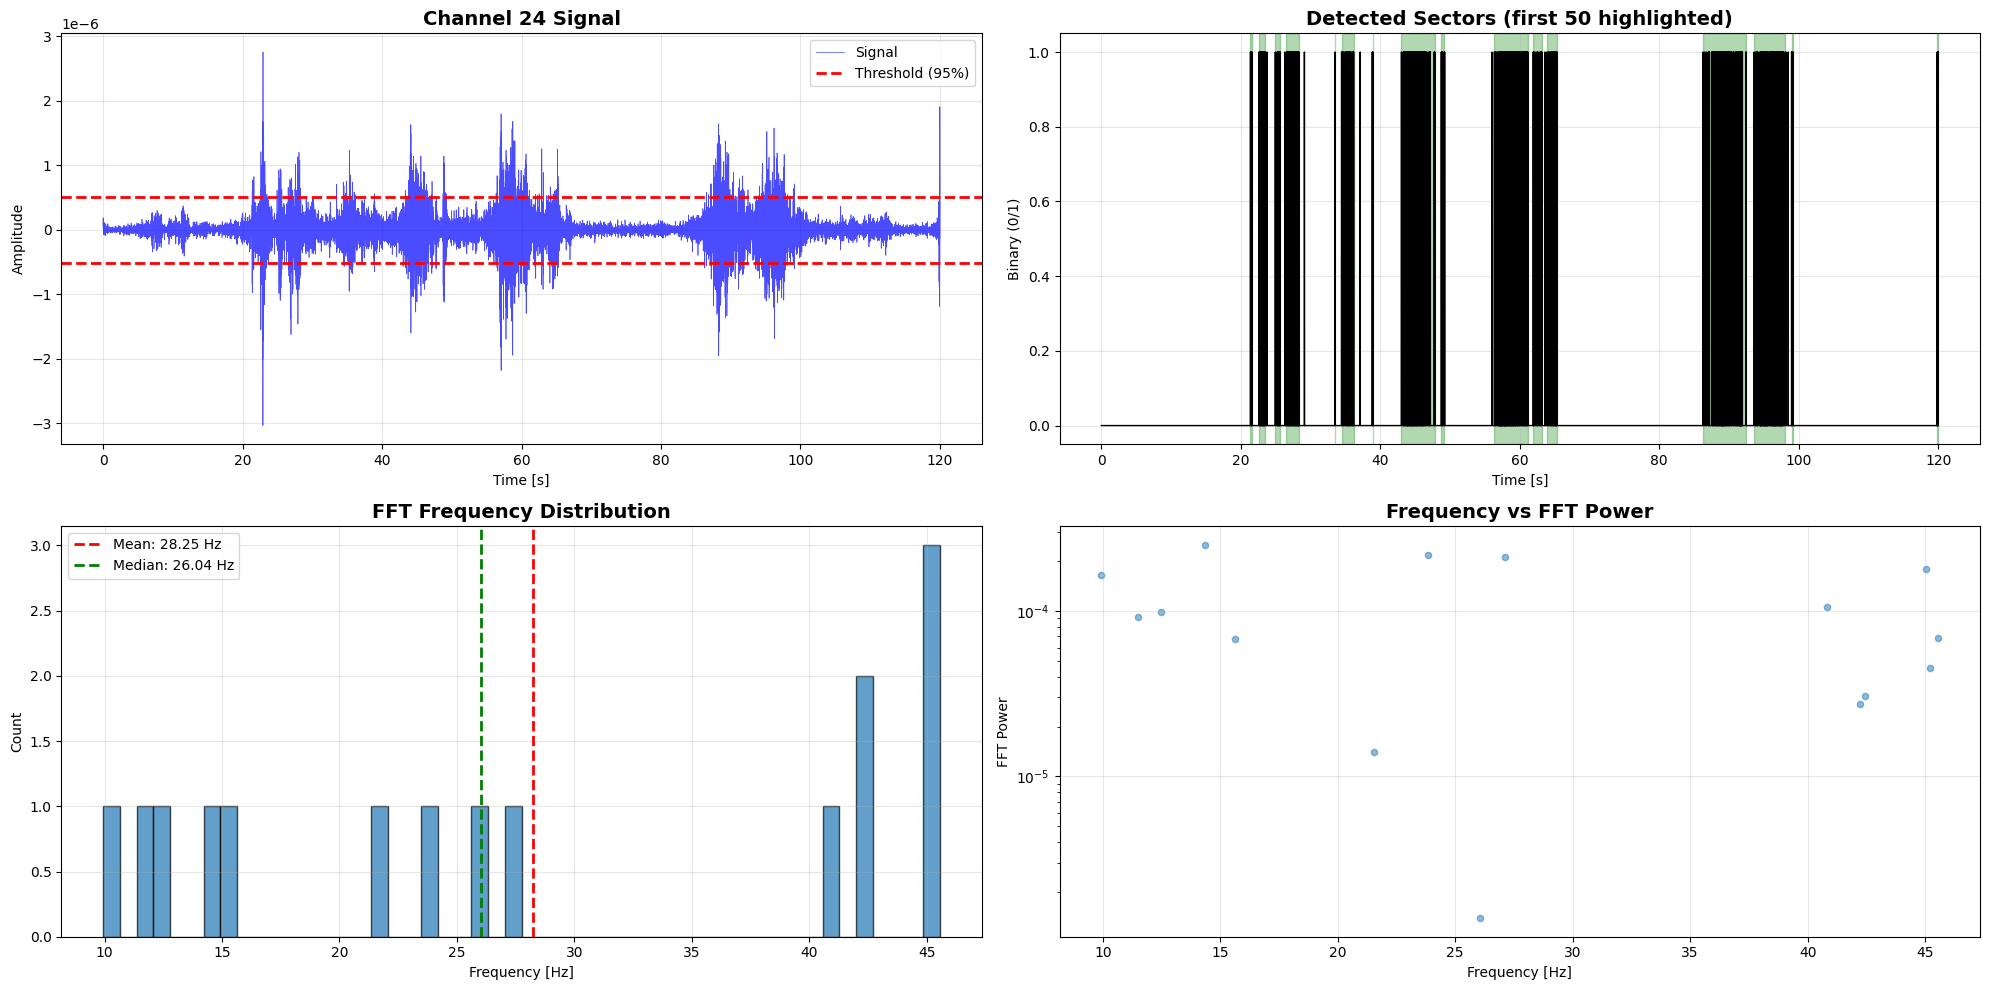



Detected frequencies (FFT): [42.4382716  40.83484574 45.55808656  9.93816254 11.49954002 26.04166667
 45.04504505 45.21276596 23.82943144 15.625      12.45847176 14.35113519
 27.12557809 21.55172414 42.22972973]
BANDSTOP FILTERING
Sampling frequency: 625.00 Hz
Removing 15 frequency bands:
  Removed 41.94-42.94 Hz (center: 42.44 Hz)
  Removed 40.33-41.33 Hz (center: 40.83 Hz)
  Removed 45.06-46.06 Hz (center: 45.56 Hz)
  Removed 40.33-41.33 Hz (center: 40.83 Hz)
  Removed 45.06-46.06 Hz (center: 45.56 Hz)
  Removed 9.44-10.44 Hz (center: 9.94 Hz)
  Removed 11.00-12.00 Hz (center: 11.50 Hz)
  Removed 9.44-10.44 Hz (center: 9.94 Hz)
  Removed 11.00-12.00 Hz (center: 11.50 Hz)
  Removed 25.54-26.54 Hz (center: 26.04 Hz)
  Removed 44.55-45.55 Hz (center: 45.05 Hz)
  Removed 25.54-26.54 Hz (center: 26.04 Hz)
  Removed 44.55-45.55 Hz (center: 45.05 Hz)
  Removed 44.71-45.71 Hz (center: 45.21 Hz)
  Removed 23.33-24.33 Hz (center: 23.83 Hz)
  Removed 44.71-45.71 Hz (center: 45.21 Hz)
  Remove

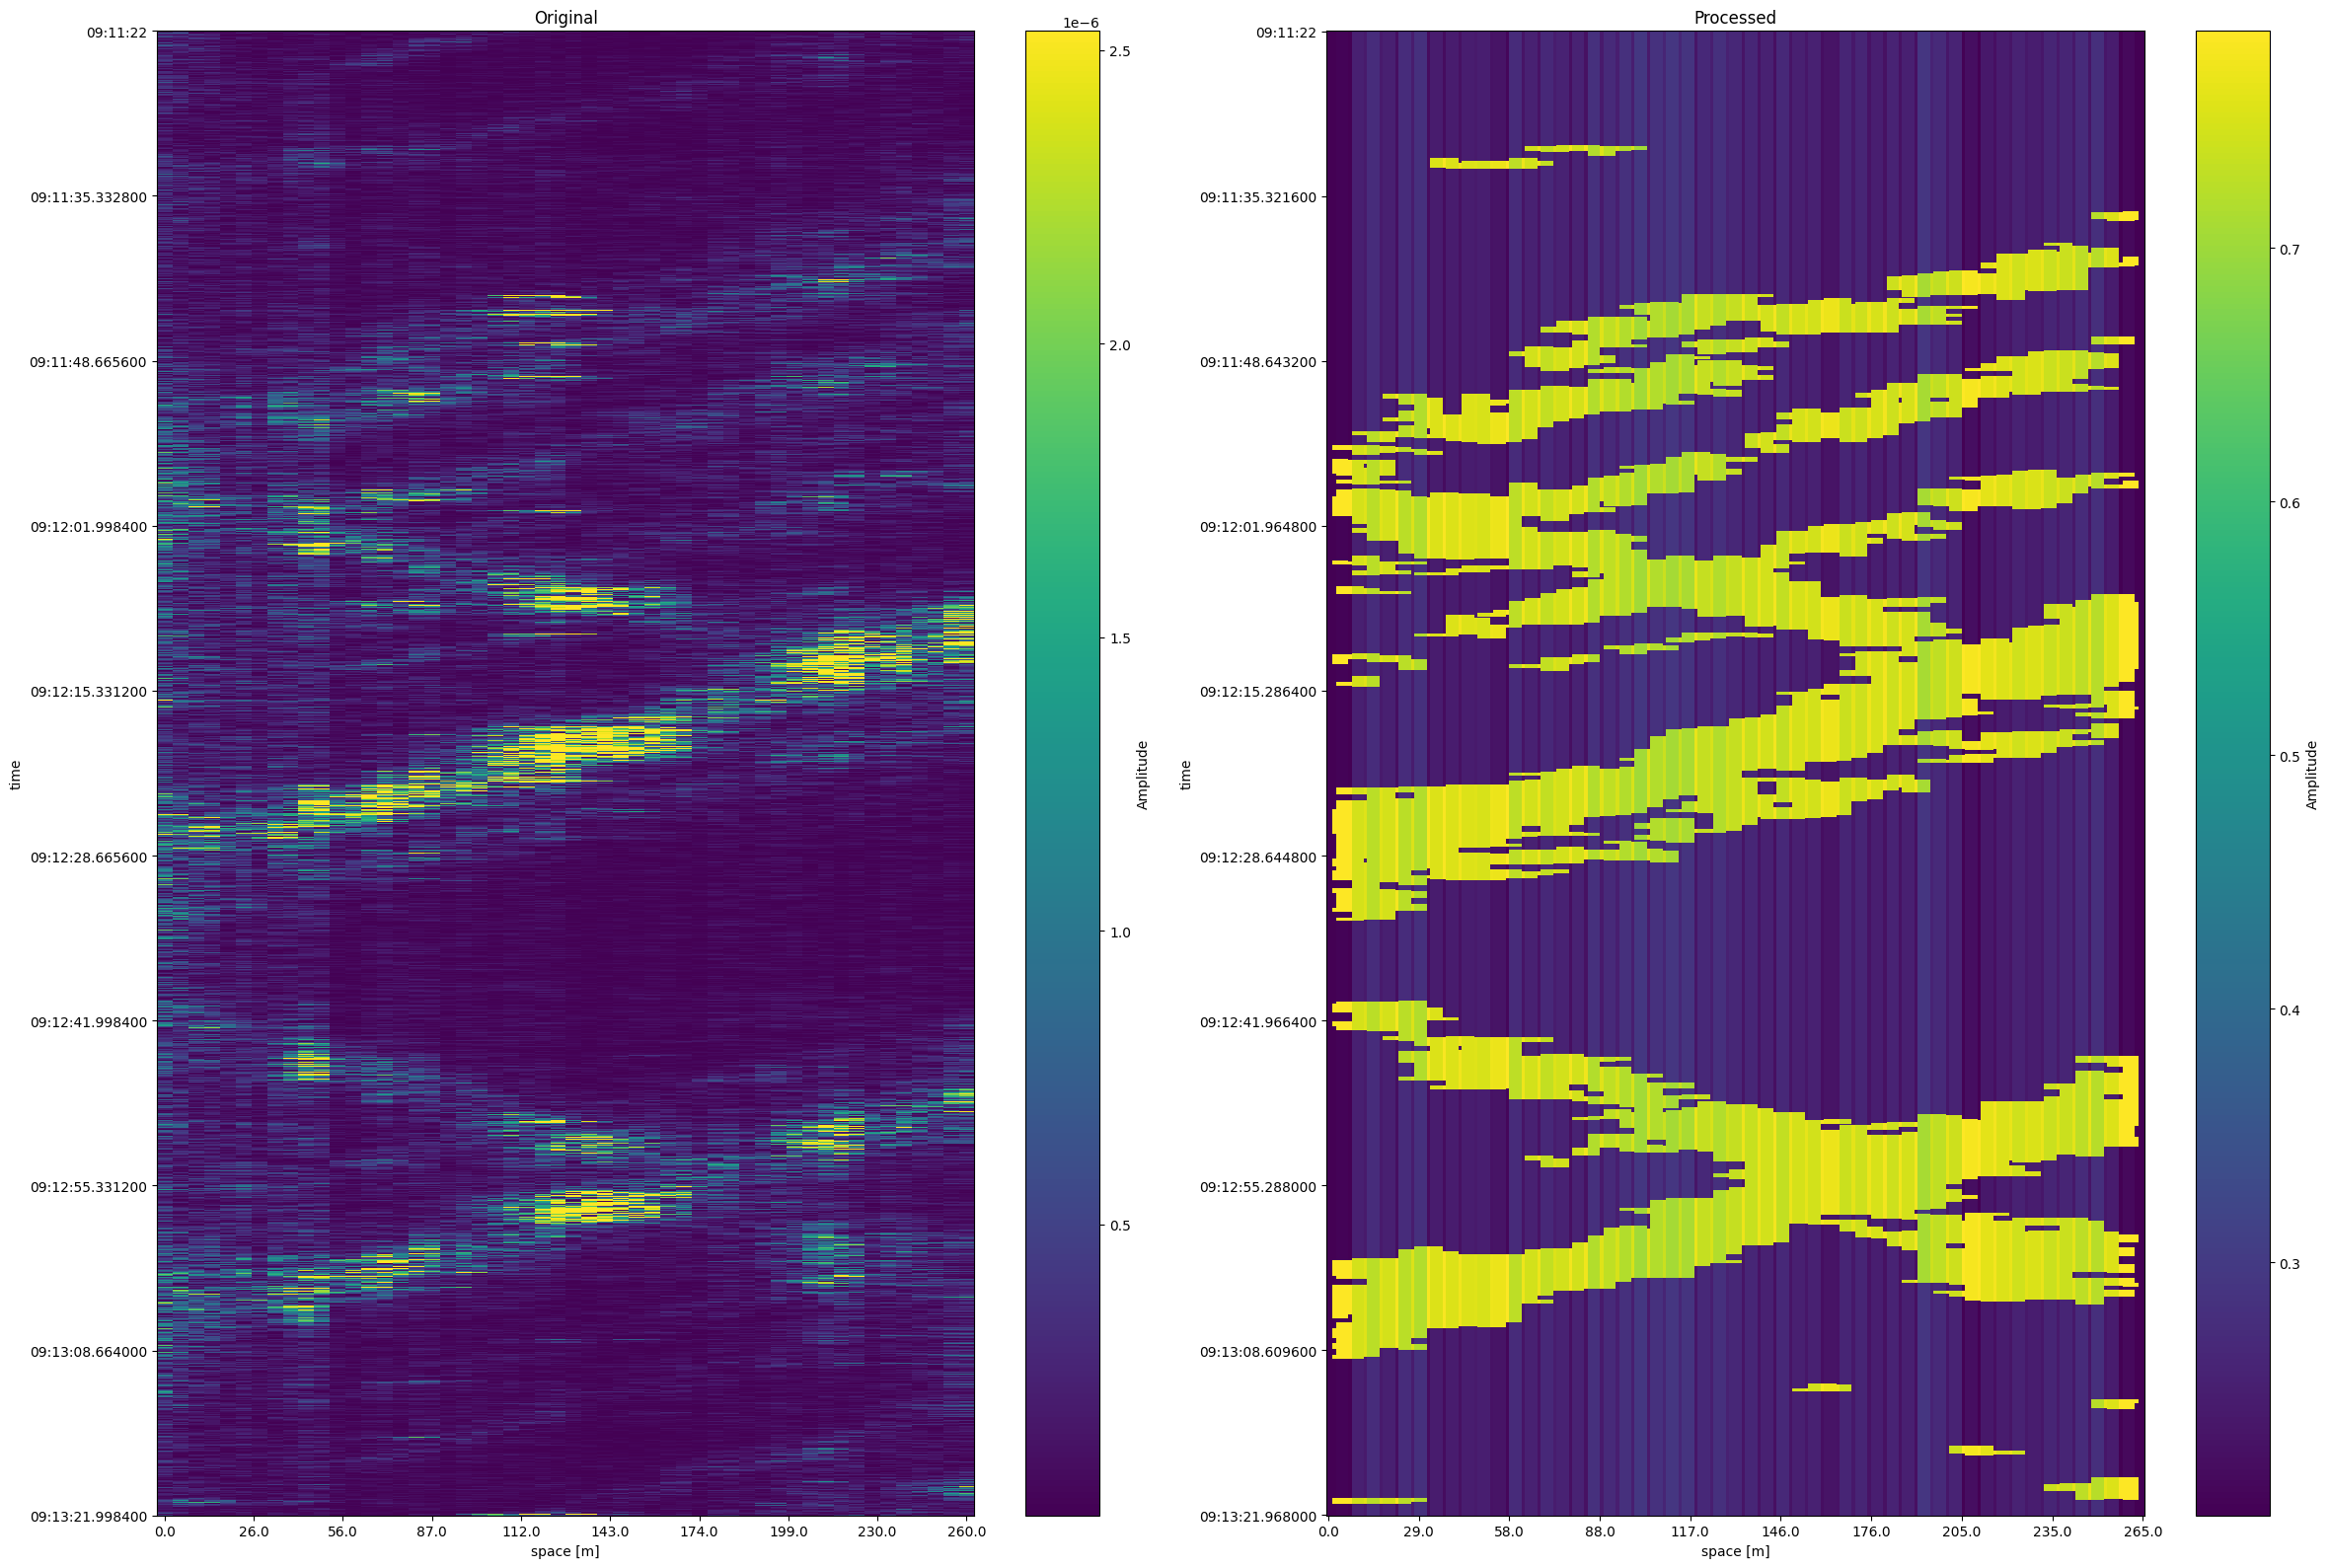

IMPERFECT LINE DETECTION (RANSAC + GAP FILLING)
Gap tolerance: 10 pixels
RANSAC residual threshold: 3 pixels
Directions: [(-30, 0), (0, 30)]

Step 1: Filling small holes in data...
Filled 27 pixels

--- Direction 1: -30° to 0° ---
Found 11 candidate regions
Detected 2 vehicles

--- Direction 2: 0° to 30° ---
Found 15 candidate regions
Detected 2 vehicles

--- Direction 2: 0° to 30° ---
Found 15 candidate regions
Detected 1 vehicles

TOTAL: 3 vehicles

Vehicle 1 [Dir 1]:
  Velocity: -2.19 m/s (-7.9 km/h)
  Angle: -4.5°
  Pixels: 3922 inliers / 131949 total
  Gaps: -2625 pixels (-202.4% of track)
  Time span: 1297 samples (47.730 s)
Vehicle 2 [Dir 1]:
  Velocity: -5.83 m/s (-21.0 km/h)
  Angle: -11.9°
  Pixels: 300 inliers / 1061 total
  Gaps: -250 pixels (-500.0% of track)
  Time span: 50 samples (1.840 s)
Vehicle 3 [Dir 2]:
  Velocity: +6.02 m/s (+21.7 km/h)
  Angle: 12.2°
  Pixels: 2621 inliers / 72910 total
  Gaps: -2085 pixels (-389.0% of track)
  Time span: 536 samples (19.725 s)
D

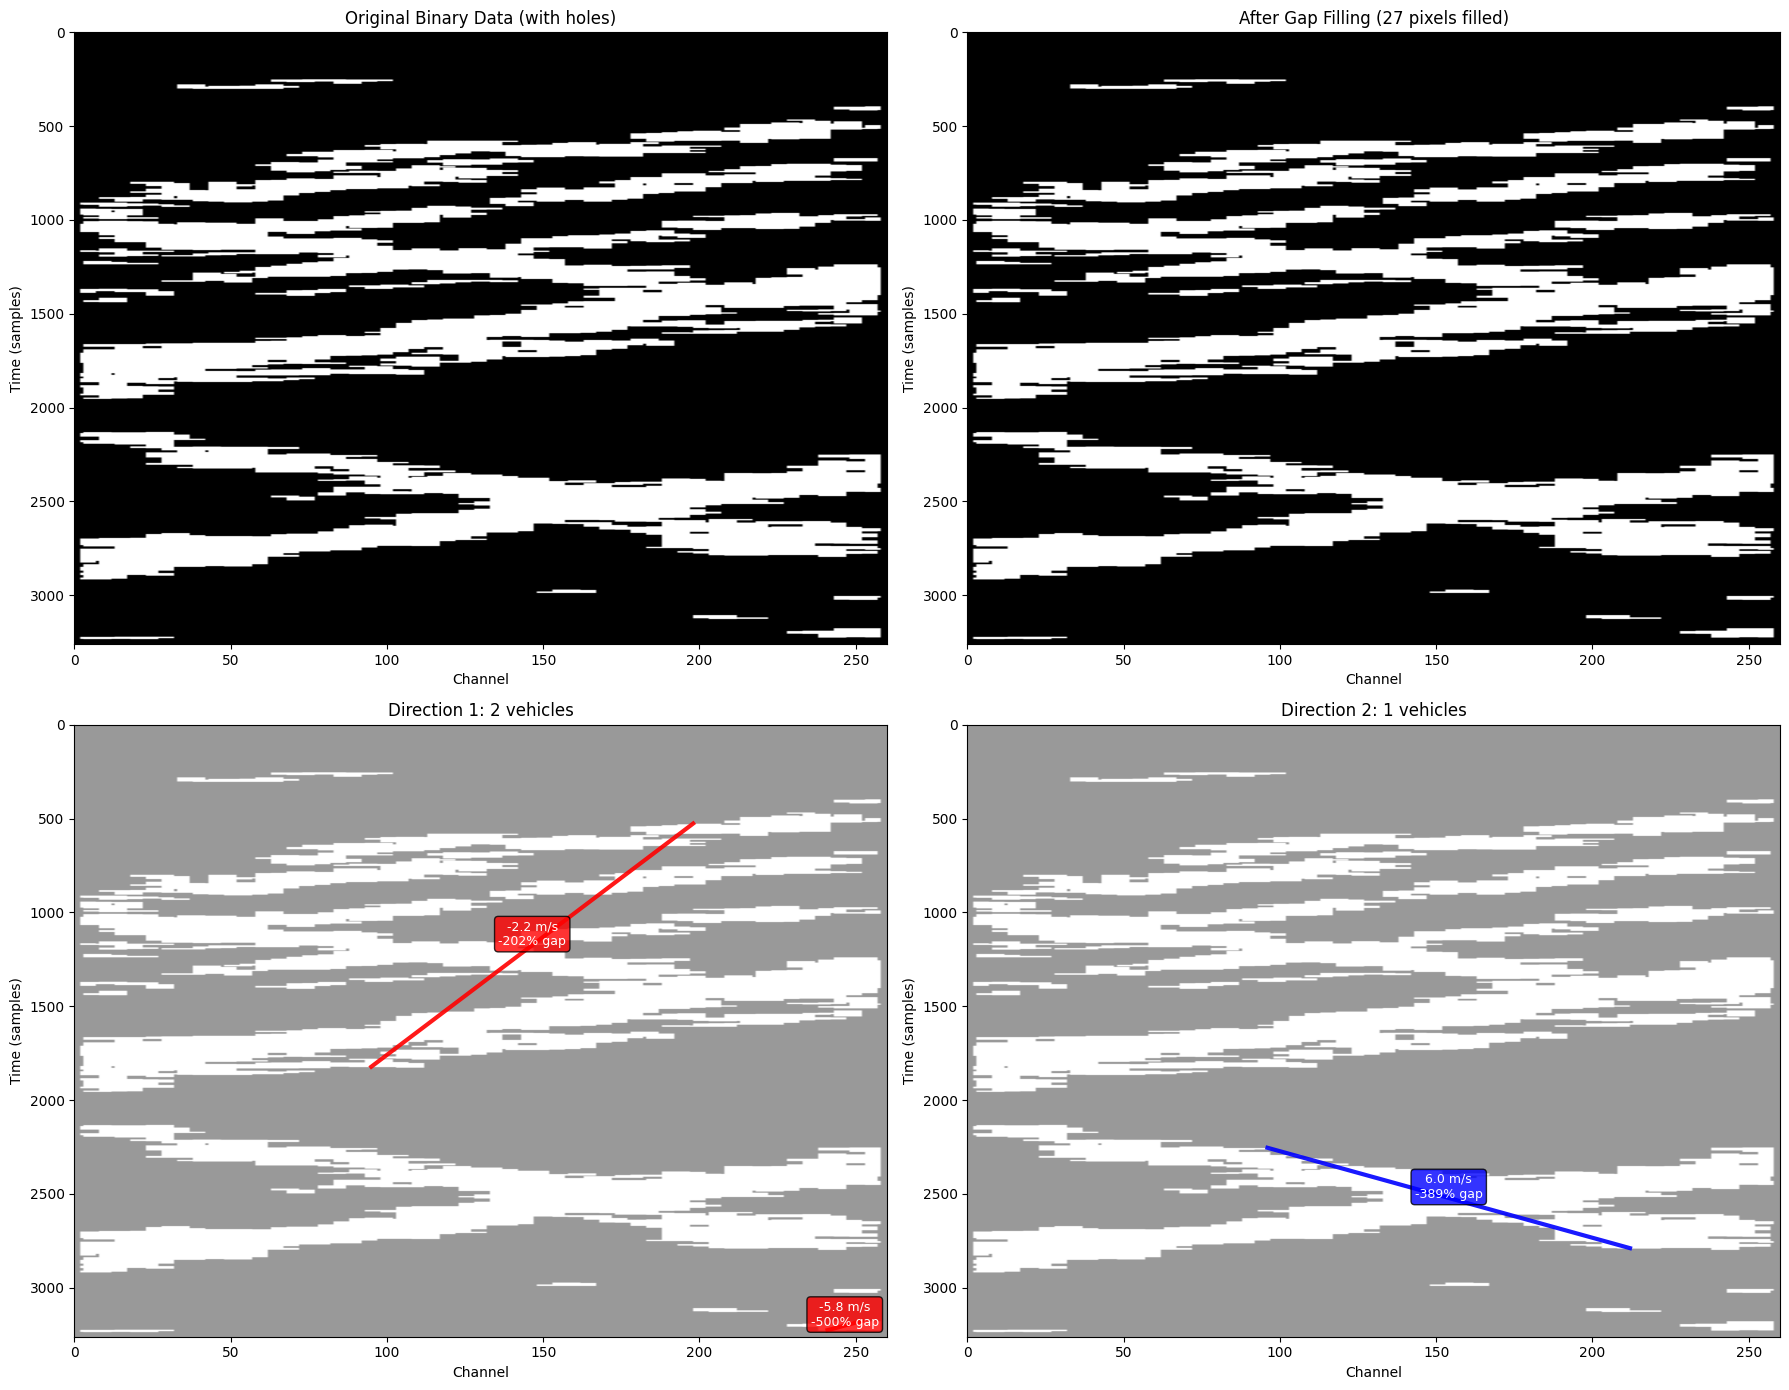

In [292]:
# Test notch filter with FFT-detected frequencies
raw_data = get_range(*range2)
data = zero_columns(raw_data, 0, 0)
bandpass_data = bandpass_filter(data, lowcut=5, highcut=50, order=4)

# Find frequencies using FFT analysis
result_fft = find_channel_frequencies_fft(bandpass_data, 
                                          channel_index=24, 
                                          threshold_percentile=95, 
                                          merge_gap=450,
                                          min_freq=5,
                                          max_freq=50,
                                          top_n_peaks=1)
print("\nDetected frequencies (FFT):", result_fft['frequencies'])

extracted_data = bandstop_filter_frequencies(bandpass_data, result_fft['frequencies'], bandwidth=1.0)
sobel_data = horizontal_sobel_filter(extracted_data)
noise_removed = noise_removal_only(sobel_data, threshold_strong_percentile=85, threshold_weak_percentile=85)
resized_data = aspect_ratio_correction(noise_removed)
print(resized_data['data'].shape, resized_data['dt'], resized_data['dx'])
binary_data = binary_threshold_filter(resized_data, threshold_percentile=75)
morph_data = morphological_closing(binary_data, structure_size=(2, 3), iterations=2, threshold_percentile=0)
morph_data = morphological_opening(morph_data, structure_size=(2, 2), iterations=2, threshold_percentile=0)
morph_data = morphological_opening(morph_data, structure_size=(4, 2), iterations=2, threshold_percentile=0)
morph_data = morphological_closing(morph_data, structure_size=(5, 1), iterations=2, threshold_percentile=0)
morph_data = morphological_opening(morph_data, structure_size=(3, 3), iterations=2, threshold_percentile=0)
final_data = remove_small_objects(morph_data, min_size=250, threshold_percentile=0)
plot_comparison(raw_data, final_data)

result = detect_imperfect_lines_ransac(final_data, angle_ranges= [(-30, 0), (0, 30)], gap_tolerance=10, min_pixels=300)